In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np
from scipy.io import mmread
import pyreadr
import anndata
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import matplotlib.patches as mpatches
import phenograph
from sklearn.neighbors import kneighbors_graph
import random
from scipy.stats import zscore, ttest_ind

### function for taking a dataframe and log-normalizing
def log_normalize(counts):
    ms = counts.sum(axis=1)
    norm_df = counts.div(ms, axis=0).mul(np.median(ms),axis=0)
    data_df = np.log(norm_df + 0.1)
    data_df = data_df.astype(np.float32)
    return data_df

### function for generating random colors for plotting
def random_colors(n): #n is the number of colors you need to generate
    color_set = np.zeros((n,3))
    for i in range(n):
        r = random.uniform(0, 1)
        b = random.uniform(0, 1)
        g = random.uniform(0, 1)
        color_set[i] = [r,b,g]
    return color_set


### takes a dictionary of gene signatures and plots average expression on umap
def plot_expression(dictionary, umap_, subset = None, zscore_ = False, fig_size = [11,8]):   
    n = len(dictionary); max_cols = 3
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    fig = plt.figure(figsize=[fig_size[0]* ncols, fig_size[1]*nrows])
    i = 0
    cmap = plt.cm.Spectral_r
        
    for sample in dictionary:
#         print(sample)
        ax = fig.add_subplot(nrows, ncols, i+1)
        c=dictionary[sample]
        umap_["c"] = c
        if subset is None:
            umap_subset = umap_
        else:
            plt.scatter(umap_['x'],umap_['y'],s=1, edgecolors='none', color ="lightgrey")
            umap_subset = umap_.loc[subset.index]
            
        umap_shuffle = umap_subset.sample(frac = 1)
        
        if zscore_ == True:
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=5,vmin =-1, vmax = 1, edgecolors='none', cmap = cmap,  c=zscore(umap_shuffle['c']))
        else: 
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=5, edgecolors='none', cmap = cmap,  c=umap_shuffle['c'])
        fig.colorbar(plot,ax=ax)
        ax.set_title(sample, fontsize = 24)
        ax.set_axis_off()
        i += 1
    fig.tight_layout()
    plt.savefig('CLLvsT_expD.eps',format = 'eps')
    plt.show()
    return

### just plots some clusters based on array, i.e. group = [0,3,4,5] would only plot clusters 0,3,4,5
def plot_someclusters(group, umap_, string = ""):
    color_set = random_colors(n_cluster_knn+2)
    plt.figure(figsize = (6,6))
    plt.scatter(umap_['x'], umap_['y'],
                s=1, edgecolors='none',color='lightgrey')
    for i,cluster in enumerate(group): 
            bool_array = umap_.cluster_number == cluster
            cells = umap_.index[bool_array]
            plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],
                    s=1, edgecolors='none', label = cluster,color=color_set[i])
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', markerscale = 6)
    plt.title(string)
    plt.show()
    return



In [4]:
t = pd.read_csv('data_df_car_t.csv', index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'data_df_car_t.csv'

In [5]:
# counts = pd.read_pickle('car_t_counts.pkl')
t

NameError: name 't' is not defined

In [34]:
counts

MIR1302-2HG  AL627309.1  AL669831.5    FAM87B  \
CARA_T4_AAACCTGAGACCGGAT    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T1_AAACCTGAGCGAAGGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T9_AAACCTGAGCGGATCA    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T4_AAACCTGAGCTAGCCC    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T0_AAACCTGAGCTGCAAG    -2.302585   -2.302585   -2.302585 -2.302585   
...                               ...         ...         ...       ...   
CARD_T7_TTGTAGGGTAGGGACT    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T7_TTTACTGCAACGATGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T7_TTTATGCAGTGATCGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T9_TTTCCTCTCTAACTCT    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T8_TTTGTCAAGTCGATAA    -2.302585   -2.302585   -2.302585 -2.302585   

                          LINC00115    FAM41C  AL645608.7  AL645608.3  \
CARA_T4_AAACCTGAGACCGGAT  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG  -2.302585 -2.302585   -2.302585   -2.302585   
...                             ...       ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA  -2.302585 -2.302585   -2.302585   -2.302585   

                            SAMD11     NOC2L  ...  AC011043.1  AL592183.1  \
CARA_T4_AAACCTGAGACCGGAT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC -2.302585  0.096463  ...   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG -2.302585  0.374814  ...   -2.302585   -2.302585   
...                            ...       ...  ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG -2.302585  0.432642  ...   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG -2.302585  1.409906  ...   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT -2.302585 -0.098999  ...   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA -2.302585  1.050534  ...   -2.302585   -2.302585   

                          AL354822.1  AC004556.1  AC233755.1  AC240274.1  \
CARA_T4_AAACCTGAGACCGGAT   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG   -2.302585   -2.302585   -2.302585   -2.302585   
...                              ...         ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA   -2.302585   -2.302585   -2.302585   -2.302585   

                          cluster_number  metacluster  time  experiment  
CARA_T4_AAACCTGAGACCGGAT              18          2.0    T4        CARA  
CARA_T1_AAACCTGAGCGAAGGG               7          2.0    T1        CARA  
CARA_T9_AAACCTGAGCGGATCA               1          2.0    T9        CARA  
CARA_T4_AAACCTGAGCTAGCCC              13          2.0    T4        CARA  
CARA_T0_AAACCTGAGCTGCAAG              19

In [35]:
counts['metacluster'] = 'x'
counts['cluster_number'] = 'x'
counts['time'] = 'x'
counts['experiment'] = 'x'


counts.loc[data_df.index,'metacluster'] = data_df['metacluster']
counts.loc[data_df.index,'cluster_number'] = data_df['cluster_number']
counts.loc[data_df.index,'time'] = data_df['time']
counts.loc[data_df.index,'experiment'] = data_df['experiment']

In [38]:
counts = counts[counts['time']!='x']
counts

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
CARA_T4_AAACCTGAGACCGGAT            0        0      0           0           0   
CARA_T1_AAACCTGAGCGAAGGG            0        0      0           0           0   
CARA_T9_AAACCTGAGCGGATCA            0        0      0           0           0   
CARA_T4_AAACCTGAGCTAGCCC            0        0      0           0           0   
CARA_T0_AAACCTGAGCTGCAAG            0        0      0           0           0   
...                               ...      ...    ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT            0        0      0           0           0   
CARD_T7_TTTACTGCAACGATGG            0        0      0           0           0   
CARD_T7_TTTATGCAGTGATCGG            0        0      0           0           0   
CARD_T9_TTTCCTCTCTAACTCT            0        0      0           0           0   
CARD_T8_TTTGTCAAGTCGATAA            0        0      0           0           0   

                          AL627309.2  AL627309.4  AL732372.1  OR4F29  \
CARA_T4_AAACCTGAGACCGGAT           0           0           0       0   
CARA_T1_AAACCTGAGCGAAGGG           0           0           0       0   
CARA_T9_AAACCTGAGCGGATCA           0           0           0       0   
CARA_T4_AAACCTGAGCTAGCCC           0           0           0       0   
CARA_T0_AAACCTGAGCTGCAAG           0           0           0       0   
...                              ...         ...         ...     ...   
CARD_T7_TTGTAGGGTAGGGACT           0           0           0       0   
CARD_T7_TTTACTGCAACGATGG           0           0           0       0   
CARD_T7_TTTATGCAGTGATCGG           0           0           0       0   
CARD_T9_TTTCCTCTCTAACTCT           0           0           0       0   
CARD_T8_TTTGTCAAGTCGATAA           0           0           0       0   

                          AC114498.1  ...  AC004556.1  AC233755.2  AC233755.1  \
CARA_T4_AAACCTGAGACCGGAT           0  ...           0           0           0   
CARA_T1_AAACCTGAGCGAAGGG           0  ...           0           0           0   
CARA_T9_AAACCTGAGCGGATCA           0  ...           0           0           0   
CARA_T4_AAACCTGAGCTAGCCC           0  ...           0           0           0   
CARA_T0_AAACCTGAGCTGCAAG           0  ...           0           0           0   
...                              ...  ...         ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT           0  ...           0           0           0   
CARD_T7_TTTACTGCAACGATGG           0  ...           0           0           0   
CARD_T7_TTTATGCAGTGATCGG           0  ...           0           0           0   
CARD_T9_TTTCCTCTCTAACTCT           0  ...           0           0           0   
CARD_T8_TTTGTCAAGTCGATAA           0  ...           0           0           0   

                          AC240274.1  AC213203.1  FAM231C  metacluster  \
CARA_T4_AAACCTGAGACCGGAT           0           0        0          2.0   
CARA_T1_AAACCTGAGCGAAGGG           0           0        0          2.0   
CARA_T9_AAACCTGAGCGGATCA           0           0        0          2.0   
CARA_T4_AAACCTGAGCTAGCCC           0           0        0          2.0   
CARA_T0_AAACCTGAGCTGCAAG           0           0        0          0.0   
...                              ...         ...      ...          ...   
CARD_T7_TTGTAGGGTAGGGACT           0           0        0          0.0   
CARD_T7_TTTACTGCAACGATGG           0           0        0          2.0   
CARD_T7_TTTATGCAGTGATCGG           0           0        0          2.0   
CARD_T9_TTTCCTCTCTAACTCT           0           0        0          0.0   
CARD_T8_TTTGTCAAGTCGATAA           0           0        0          2.0   

                          cluster_number  time  experiment  
CARA_T4_AAACCTGAGACCGGAT              18    T4        CARA  
CARA_T1_AAACCTGAGCGAAGGG               7    T1        CARA  
CARA_T9_AAACCTGAGCGGATCA               1    T9        CARA  
CARA_T4_AAACCTGAGCTAGCCC              13    T4        CARA  
CARA_T0_AAACCTGAGCTGC

In [39]:
counts.to_csv('counts_car_t.csv')

In [5]:
test = pd.read_pickle('car_t_umap_expC.pkl')
test = pd.read_pickle('car_t_metacluster_ratios_revised.pkl')
# test.to_csv('car_t_umap_expC.pkl')
test

0         1         2  total_cells_per_sample
T0  0.000000  0.428571  0.285714                    14.0
T1  0.785714  0.035714  0.178571                    28.0
T2  0.657718  0.087248  0.228188                   149.0
T3  0.448669  0.114068  0.437262                   263.0
T4  0.406619  0.033097  0.536643                   423.0
T5  0.496454  0.017730  0.379433                   282.0
T6  0.280992  0.006198  0.522727                   968.0
T7  0.129813  0.016336  0.181739                  3428.0
T8  0.083149  0.008869  0.046933                  2706.0
T9  0.056049  0.013041  0.151776                  3604.0

In [17]:
data_df['sample_time'] = [cell.split('_')[0]+'_'+cell.split('_')[1] for cell in data_df.index]


In [18]:
a,c = np.unique(data_df['sample_time'], return_counts = True)
a,c

(array(['CARA_T0', 'CARA_T1', 'CARA_T2', 'CARA_T3', 'CARA_T4', 'CARA_T5',
        'CARA_T6', 'CARA_T7', 'CARA_T8', 'CARA_T9', 'CARB_T1', 'CARB_T2',
        'CARB_T3', 'CARB_T4', 'CARB_T5', 'CARC_T0', 'CARC_T1', 'CARC_T2',
        'CARC_T3', 'CARC_T4', 'CARC_T5', 'CARC_T6', 'CARC_T7', 'CARC_T8',
        'CARC_T9', 'CARD_T0', 'CARD_T1', 'CARD_T2', 'CARD_T3', 'CARD_T4',
        'CARD_T5', 'CARD_T6', 'CARD_T7', 'CARD_T8', 'CARD_T9'],
       dtype=object),
 array([ 190,  112,  263,  390,  756,  375,  580,  704,  872, 7756,  699,
        1502, 2714, 2107, 5225,    3,  289,  545,  431,  994, 1065, 1248,
        2591, 2454, 4219,   13,  120,  411,  609,  790,  468, 1200, 2774,
        1890, 2924]))

In [19]:
d = pd.DataFrame({'time':a,'counts':c})
d.to_csv('counts_cart_bytimeandsample.csv')

In [6]:
## load in data, data_df already log normalized
data_df=pd.read_pickle("./data_df_revised_clusters.pkl")
umap_ = pd.read_pickle("umap_car_t_subset.pkl")
# data_df = data_df[data_df.index.isin(umap_.index)]
# data_df['metacluster'] = umap_.loc[data_df.index, 'metacluster']
# umap_ = pd.read_pickle("car_t_umap_expC.pkl")

In [20]:
data_df['time'] = 'x'
for cell in data_df.index: 
    T = cell.split('_')[1]
    data_df.loc[cell,'time'] = T
    

In [26]:
data_df['experiment'] = [cell.split('_')[0] for cell in data_df.index]
data_df

MIR1302-2HG  AL627309.1  AL669831.5    FAM87B  \
CARA_T4_AAACCTGAGACCGGAT    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T1_AAACCTGAGCGAAGGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T9_AAACCTGAGCGGATCA    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T4_AAACCTGAGCTAGCCC    -2.302585   -2.302585   -2.302585 -2.302585   
CARA_T0_AAACCTGAGCTGCAAG    -2.302585   -2.302585   -2.302585 -2.302585   
...                               ...         ...         ...       ...   
CARD_T7_TTGTAGGGTAGGGACT    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T7_TTTACTGCAACGATGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T7_TTTATGCAGTGATCGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T9_TTTCCTCTCTAACTCT    -2.302585   -2.302585   -2.302585 -2.302585   
CARD_T8_TTTGTCAAGTCGATAA    -2.302585   -2.302585   -2.302585 -2.302585   

                          LINC00115    FAM41C  AL645608.7  AL645608.3  \
CARA_T4_AAACCTGAGACCGGAT  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC  -2.302585 -2.302585   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG  -2.302585 -2.302585   -2.302585   -2.302585   
...                             ...       ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT  -2.302585 -2.302585   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA  -2.302585 -2.302585   -2.302585   -2.302585   

                            SAMD11     NOC2L  ...  AC011043.1  AL592183.1  \
CARA_T4_AAACCTGAGACCGGAT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC -2.302585  0.096463  ...   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG -2.302585  0.374814  ...   -2.302585   -2.302585   
...                            ...       ...  ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG -2.302585  0.432642  ...   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG -2.302585  1.409906  ...   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT -2.302585 -0.098999  ...   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA -2.302585  1.050534  ...   -2.302585   -2.302585   

                          AL354822.1  AC004556.1  AC233755.1  AC240274.1  \
CARA_T4_AAACCTGAGACCGGAT   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T1_AAACCTGAGCGAAGGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T9_AAACCTGAGCGGATCA   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T4_AAACCTGAGCTAGCCC   -2.302585   -2.302585   -2.302585   -2.302585   
CARA_T0_AAACCTGAGCTGCAAG   -2.302585   -2.302585   -2.302585   -2.302585   
...                              ...         ...         ...         ...   
CARD_T7_TTGTAGGGTAGGGACT   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T7_TTTACTGCAACGATGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T7_TTTATGCAGTGATCGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T9_TTTCCTCTCTAACTCT   -2.302585   -2.302585   -2.302585   -2.302585   
CARD_T8_TTTGTCAAGTCGATAA   -2.302585   -2.302585   -2.302585   -2.302585   

                          cluster_number  metacluster  time  experiment  
CARA_T4_AAACCTGAGACCGGAT              18          2.0    T4        CARA  
CARA_T1_AAACCTGAGCGAAGGG               7          2.0    T1        CARA  
CARA_T9_AAACCTGAGCGGATCA               1          2.0    T9        CARA  
CARA_T4_AAACCTGAGCTAGCCC              13          2.0    T4        CARA  
CARA_T0_AAACCTGAGCTGCAAG              19

In [27]:
data_df.to_csv('data_car_t.csv')

In [30]:
arr = []
arr1 = []
for cell in data_df.index:
    exp = data_df.loc[cell,'experiment']
    time = data_df.loc[cell,'time']
    input_string = exp+'_'+time
    arr.append(input_string)
    input_string = 'MEC1/CART'+', ' + exp +  ', ' + time
    arr1.append(input_string)
    
arr_u = np.unique(arr)
arr1_u = np.unique(arr1)

df = pd.DataFrame({'samp':arr_u, 'title': arr1_u})
df

samp                title
0   CARA_T0  MEC1/CART, CARA, T0
1   CARA_T1  MEC1/CART, CARA, T1
2   CARA_T2  MEC1/CART, CARA, T2
3   CARA_T3  MEC1/CART, CARA, T3
4   CARA_T4  MEC1/CART, CARA, T4
5   CARA_T5  MEC1/CART, CARA, T5
6   CARA_T6  MEC1/CART, CARA, T6
7   CARA_T7  MEC1/CART, CARA, T7
8   CARA_T8  MEC1/CART, CARA, T8
9   CARA_T9  MEC1/CART, CARA, T9
10  CARB_T1  MEC1/CART, CARB, T1
11  CARB_T2  MEC1/CART, CARB, T2
12  CARB_T3  MEC1/CART, CARB, T3
13  CARB_T4  MEC1/CART, CARB, T4
14  CARB_T5  MEC1/CART, CARB, T5
15  CARC_T1  MEC1/CART, CARC, T1
16  CARC_T2  MEC1/CART, CARC, T2
17  CARC_T3  MEC1/CART, CARC, T3
18  CARC_T4  MEC1/CART, CARC, T4
19  CARC_T5  MEC1/CART, CARC, T5
20  CARC_T6  MEC1/CART, CARC, T6
21  CARC_T7  MEC1/CART, CARC, T7
22  CARC_T8  MEC1/CART, CARC, T8
23  CARC_T9  MEC1/CART, CARC, T9
24  CARD_T1  MEC1/CART, CARD, T1
25  CARD_T2  MEC1/CART, CARD, T2
26  CARD_T3  MEC1/CART, CARD, T3
27  CARD_T4  MEC1/CART, CARD, T4
28  CARD_T5  MEC1/CART, CARD, T5
29  CARD_T6  MEC1/CART, CARD, T6
30  CARD_T7  MEC1/CART, CARD, T7
31  CARD_T8  MEC1/CART, CARD, T8
32  CARD_T9  MEC1/CART, CARD, T9

In [31]:
df.to_csv('meta.csv')

In [21]:
data_a = data_df[data_df.index.str.contains('CARA')]
data_b = data_df[data_df.index.str.contains('CARB')]
data_d = data_df[data_df.index.str.contains('CARD')]
data_b_1 = data_b[data_b.index.str.contains('A_')]
data_b_2 = data_b[~data_b.index.isin(data_b_1.index)]

In [24]:
data_a.to_csv('DATA_A.csv')
data_b_1.to_csv('DATA_B1.csv')
data_b_2.to_csv('DATA_B2.csv')
data_d.to_csv('DATA_D.csv')

In [3]:
umap_ = umap_.dropna(axis = 0, how = 'any')

In [15]:
# ### just saving all the t cell data to csv
# df = data_df.loc[umap_.index[umap_['metacluster']!= 0]]
# df.to_csv('t_cells.csv')

In [4]:
data_df = data_df.loc[umap_.index]

In [5]:
data_c = data_df[data_df.index.str.contains('CARC')]
data_c

MIR1302-2HG  AL627309.1  AL669831.5    FAM87B  \
CARC_T8_AAACCTGAGAAGGCCT    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG    -2.302585   -2.302585   -2.302585 -2.302585   
...                               ...         ...         ...       ...   
CARC_T9_TTTGTCATCATGTAGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT    -2.302585   -2.302585   -2.302585 -2.302585   

                          LINC00115    FAM41C  AL645608.7  AL645608.3  \
CARC_T8_AAACCTGAGAAGGCCT  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  -2.302585 -2.302585   -2.302585   -2.302585   
...                             ...       ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG  -0.744831 -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT  -2.302585 -2.302585   -2.302585   -2.302585   

                            SAMD11     NOC2L  ...  BX004987.1  AC145212.1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -0.633307  ...   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -0.990700  ...   -2.302585   -2.302585   
...                            ...       ...  ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -0.445403  ...   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -0.281202  ...   -2.302585   -2.302585   

                             MAFIP  AC011043.1  AL592183.1  AL354822.1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585   -2.302585   -2.302585   -2.302585   
...                            ...         ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585   -2.302585   -2.302585   -2.302585   

                          AC004556.1  AC233755.1  AC240274.1  cluster_number  
CARC_T8_AAACCTGAGAAGGCCT   -2.302585   -2.302585   -2.302585              12  
CARC_T9_AAACCTGAGACAAGCC   -2.302585   -2.302585   -2.302585               3  
CARC_T6_AAACCTGAGACAATAC   -2.302585   -2.302585   -2.302585               3  
CARC_T9_AAACCTGAGCCATCGC   -2.302585   -2.302585   -2.302585              10  
CARC_T2_AAACCTGAGGTAGCTG   -2.302585   

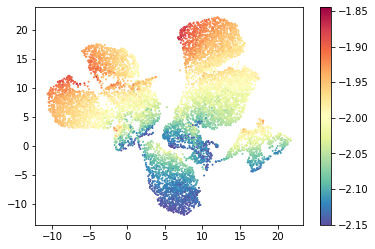

In [6]:
pca = PCA(n_components=8)
pca_projections = pd.DataFrame(pca.fit_transform(data_c), index = data_c.index)
umap_data = umap.UMAP(n_neighbors = 10, min_dist=0.8)
results = umap_data.fit_transform(pca_projections);
umap_ = pd.DataFrame(results, index=data_c.index, columns=['x', 'y'])
plt.figure()
plt.scatter(umap_['x'],umap_['y'], s= 1, cmap = plt.cm.Spectral_r, c = data_c.mean(axis = 1))
plt.colorbar()
plt.show()
umap_.to_pickle("car_t_umap_expC.pkl")

In [13]:
umap_

x          y          c_time   c_exp  \
CARA_T9_AAACCTGAGAATAGGG -0.854431   4.830726            cyan    blue   
CARA_T5_AAACCTGAGACAGGCT -3.054501   1.719231        darkblue    blue   
CARA_T4_AAACCTGAGACCGGAT  2.042165   7.307134            blue    blue   
CARA_T1_AAACCTGAGCGAAGGG  6.289377  13.234041          violet    blue   
CARA_T9_AAACCTGAGCGGATCA  6.609953  14.180170            cyan    blue   
...                            ...        ...             ...     ...   
CARD_T4_TTTCCTCGTCGATTGT -0.867883   6.768141            blue  orange   
CARD_T9_TTTCCTCTCTAACTCT  0.139499   6.792211            cyan  orange   
CARD_T9_TTTGCGCCATGGTCTA -0.950873   6.206651            cyan  orange   
CARD_T7_TTTGGTTCATGGTAGG -1.217489   1.876974  cornflowerblue  orange   
CARD_T8_TTTGTCAAGTCGATAA  2.306681  11.745119       lightblue  orange   

                          metacluster  cluster_number  
CARA_T9_AAACCTGAGAATAGGG          0.0               8  
CARA_T5_AAACCTGAGACAGGCT          0.0               4  
CARA_T4_AAACCTGAGACCGGAT          2.0              20  
CARA_T1_AAACCTGAGCGAAGGG          2.0               2  
CARA_T9_AAACCTGAGCGGATCA          2.0               2  
...                               ...             ...  
CARD_T4_TTTCCTCGTCGATTGT          0.0              21  
CARD_T9_TTTCCTCTCTAACTCT          0.0              21  
CARD_T9_TTTGCGCCATGGTCTA          0.0              21  
CARD_T7_TTTGGTTCATGGTAGG          0.0              10  
CARD_T8_TTTGTCAAGTCGATAA          2.0              14  

[34199 rows x 6 columns]

In [12]:
# data_df = pd.read_pickle("data_df_clusters.pkl")
umap_ = pd.read_pickle("umap_car_t_subset.pkl")
# umap_ = pd.read_pickle("umap_with_time_colors.pkl")
# test = pd.read_pickle("car_t_metacluster_ratios.pkl")
# umap_ = pd.read_pickle("umap_car_t_subset.pkl")

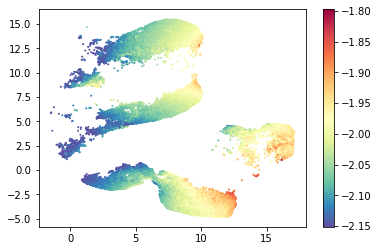

In [8]:
plt.figure()
plt.scatter(umap_['x'],umap_['y'], s= 1, cmap = plt.cm.Spectral_r, c = data_df.mean(axis = 1))
plt.colorbar()
plt.show()

In [5]:
# ### code used for filtering out empty dropletsplt.figure()
# plt.hist(data_df.mean(axis = 1),bins = 100)
# plt.show()

# cells = data_df.index[data_df.mean(axis = 1)>=-2.15]

# plt.figure()
# plt.scatter(umap_.loc[:,'x'],umap_.loc[:,'y'],s=1,  color = 'lightgrey')
# plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'],s=1,  color = 'lightgreen')
# plt.title('Avg log library size > -2.14')
# plt.show()

# umap_ = umap_.loc[cells]
# data_df = data_df.loc[cells]

# Updating umap to include time ad experiment, reclustering to get metaclusters

In [6]:
time = []
data = []
for cell in umap_.index:
    time_ = cell.split('_')[1]
    data_ = cell.split('_')[0]
    
    
    if data_ == 'CARB':
        data_subset = cell.split('_')[2]
        if data_subset == 'A':
            data_ = data_ + '_14'
        elif data_subset == 'B':
            data_ = data_ + '_41'
            
        if time_ == 'T1':
            time_ = 'T2'
        elif time_ == 'T2':
            time_ = 'T5'
        elif time_ == 'T3':
            time_ = 'T7'
        elif time_ == 'T4':
            time_ = 'T8'
        elif time_ == 'T5':
            time_ = 'T9'
        
    data.append(data_)
    time.append(time_)

## 15 min=T1 -> T2, 1hr=T2 -> T5, 4hr=T3 -> T7, 12=T4 -> T8, 24 =T5 -> T9
    
umap_['DATA']=data
umap_['time'] = time
umap_['cluster_number'] = data_c['cluster_number']

In [7]:
# umap_.loc[cells]

In [9]:
for i,time_ in enumerate(time_arr[::-1]):
    plt.figure(figsize = [8,8])
    plt.scatter(umap_.loc[:,'x'],umap_.loc[:,'y'], s = 3, color = 'lightgrey')
    cells = umap_.index[umap_['time']==time_]
    plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 3, color = time_color[len(time_color)-i-1], label = time_)
    plt.title(time_)


NameError: name 'time_arr' is not defined

In [14]:
umap_[umap_['time']=='T0']

x          y  DATA time  cluster_number
CARC_T0_CTCTAATCACGGTAGA  7.747228  -4.781741  CARC   T0               3
CARC_T0_CTGATAGGTAGAGGAA  7.935199 -11.751320  CARC   T0               3
CARC_T0_TCATTTGCACGGCTAC  8.042345  -4.686677  CARC   T0               3

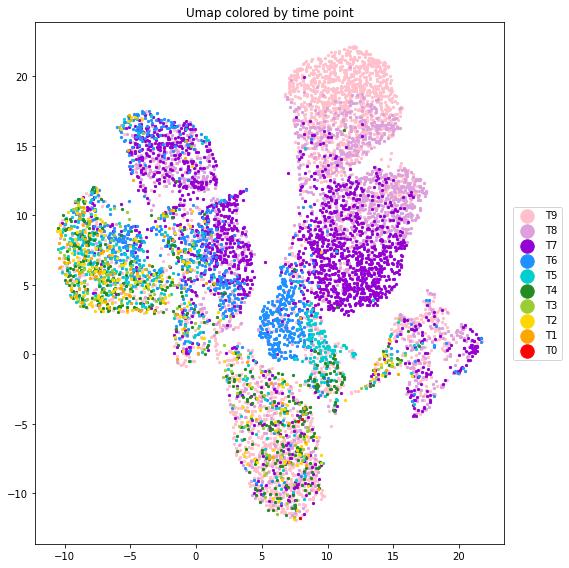

In [8]:
time_arr = np.unique(umap_['time'])
experiments = np.unique(umap_['DATA'])

exp_color = ["blue", 'green','darkgreen','red','orange']
time_color = ['red','orange','gold','yellowgreen','forestgreen',
             'darkturquoise','dodgerblue','darkviolet','plum','pink']


# DF = umap_.sample(frac = 1)
plt.figure(figsize = [8,8])
for i,time_ in enumerate(time_arr[::-1]):
    cells = umap_.index[umap_['time']==time_]
    plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 5, color = time_color[len(time_color)-i-1], label = time_)
plt.title("Umap colored by time point")

color_set = time_color
plt.legend(markerscale = 6, bbox_to_anchor = (1.01,0.5), loc = 'center left')
# db = mpatches.Patch(color=color_set[0], label=time[0])
# dsb = mpatches.Patch(color=color_set[1], label=time[1])
# pdb = mpatches.Patch(color=color_set[2], label=time[2])
# do = mpatches.Patch(color=color_set[3], label=time[3])
# fg = mpatches.Patch(color=color_set[4], label=time[4])
# gy = mpatches.Patch(color=color_set[5], label=time[5])
# indigo = mpatches.Patch(color=color_set[6], label=time[6])
# yellow = mpatches.Patch(color=color_set[7], label=time[7])
# red = mpatches.Patch(color = color_set[8], label=time[8])
# grey = mpatches.Patch(color=color_set[9], label=time[9])
# plt.legend(bbox_to_anchor=(1.01, 0.4), loc='center left',handles=[db,dsb,pdb,do,fg,gy,indigo,yellow,red,grey])
plt.tight_layout()
# plt.savefig('cart_umap_time_expC.eps', format = 'eps')
plt.show()


# plt.figure(figsize = [12,12])

# for i,exp in enumerate(experiments):
#     print(exp)
#     cells = umap_.index[umap_['DATA']==exp]
#     plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, color = exp_color[i])
    
    
# plt.title("Umap colored by experiment")

# col_arr = exp_color

# db = mpatches.Patch(color=col_arr[0], label=experiments[0])
# dsb = mpatches.Patch(color=col_arr[1], label=experiments[1])
# pdb = mpatches.Patch(color=col_arr[2], label=experiments[2])
# do = mpatches.Patch(color=col_arr[3], label=experiments[3])
# dd = mpatches.Patch(color=col_arr[4], label=experiments[4])
# plt.legend(bbox_to_anchor=(1.01, 0.4), loc='center left',handles=[db,dsb,pdb,do,dd])
# plt.show()



In [16]:
counts = pd.read_pickle("counts_nonzero_genes.pkl")

In [ ]:
counts = counts.loc[umap_.index]

In [14]:
data_df

MIR1302-2HG  AL627309.1  AL669831.5    FAM87B  \
CARC_T8_AAACCTGAGAAGGCCT    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG    -2.302585   -2.302585   -2.302585 -2.302585   
...                               ...         ...         ...       ...   
CARC_T9_TTTGTCATCATGTAGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT    -2.302585   -2.302585   -2.302585 -2.302585   

                          LINC00115    FAM41C  AL645608.7  AL645608.3  \
CARC_T8_AAACCTGAGAAGGCCT  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  -2.302585 -2.302585   -2.302585   -2.302585   
...                             ...       ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG  -0.744831 -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT  -2.302585 -2.302585   -2.302585   -2.302585   

                            SAMD11     NOC2L  ...  BX004987.1  AC145212.1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -0.633307  ...   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -0.990700  ...   -2.302585   -2.302585   
...                            ...       ...  ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -0.445403  ...   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585  ...   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -0.281202  ...   -2.302585   -2.302585   

                             MAFIP  AC011043.1  AL592183.1  AL354822.1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585   -2.302585   -2.302585   -2.302585   
...                            ...         ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585   -2.302585   -2.302585   -2.302585   

                          AC004556.1  AC233755.1  AC240274.1  cluster_number  
CARC_T8_AAACCTGAGAAGGCCT   -2.302585   -2.302585   -2.302585              12  
CARC_T9_AAACCTGAGACAAGCC   -2.302585   -2.302585   -2.302585               3  
CARC_T6_AAACCTGAGACAATAC   -2.302585   -2.302585   -2.302585               3  
CARC_T9_AAACCTGAGCCATCGC   -2.302585   -2.302585   -2.302585              10  
CARC_T2_AAACCTGAGGTAGCTG   -2.302585   

In [15]:
### KNN graph

# counts = pd.read_pickle("counts_nonzero_genes.pkl")
# binary = np.sign(counts)
# ms_gene = binary.sum(axis = 0)
# use_genes = ms_gene.index[ms_gene>=1]
# counts = counts[use_genes]
# filtered = log_normalize(counts)
# pca = PCA(n_components=15)
# pca_projections = pd.DataFrame(pca.fit_transform(filtered), index = filtered.index)
# # pca_projections.to_pickle("pca_projections.pkl")

# knn = kneighbors_graph(pca_projections,n_neighbors = 15, mode='distance', metric = 'minkowski', include_self = True)
# communities, graph, Q = phenograph.cluster(knn)
# n_cluster_knn = np.amax(communities)
# data_df["cluster_number"] = communities
# # data_df.to_pickle("./data_df_revised_clusters.pkl")
umap_['cluster_number'] = data_df['cluster_number']
# df = umap_
# n_cluster_knn = np.amax(umap_['cluster_number'])
communities = umap_['cluster_number']
plt.figure(figsize=(10,8))
# color_set_clusters = random_colors(30 + 2)
#loop through labels and plot each cluster
df = umap_
low = []
high = []
for cluster in np.unique(umap_['cluster_number']):

    #add data points 
    cells = df.index[communities == cluster]
    if len(cells)<50: 
        low.append(cluster)
        continue
    high.append(cluster)
#     plt.scatter(x=df.loc[cells, 'x'], 
#                 y=df.loc[cells, 'y'], s=2,
#                 color=color_set_clusters[cluster], label = cluster,
#                 alpha=1)
    
#     #add label
#     plt.annotate(cluster, 
#                  df.loc[cells,['x','y']].mean(),
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  size=14, weight = 'bold',
#                  color='white',
#                  backgroundcolor=color_set_clusters[cluster]) 

    
    
# plt.legend(bbox_to_anchor=(1.01, 0.4), loc='center left', markerscale = 8, ncol = 2)
# plt.tight_layout()
# # plt.savefig('umap_D_clusters.eps', format = 'eps')
# plt.title("colored by cluster IDs")
# plt.show()

<Figure size 720x576 with 0 Axes>

In [74]:
# data_df.to_pickle("./data_df_revised_clusters.pkl")

In [80]:
low

[0, 1, 7, 11, 14, 15, 19, 24]

In [28]:
cell_dict = OrderedDict()
# cell_dict['CLL'] = ['CD19','CD40LG','IGHD','EBF1','TCF3','CD1C','CD19','MS4A1','CR2','CD27', 'CD22', 
#                        'CD79A', 'CD79B', 'POU2F2', 'IGHG1', 'IGHM', 'CD19', 'MS4A1', 'EBF1', 'PAX5']
cell_dict['CLL'] = ["IGKC", "CD79A", "MS4A1", "CD19"]
cell_dict['t_cell'] = ['CD3D','CD3E']
# cell_dict['CD8'] = ['CD8A','CD8B']
# cell_dict['prolif'] = ['MKI67', 'PCNA'] 

cell_dict['exhausted'] = ['TIGIT','CTLA4','PDCD1','IL10','TGFB1','LAG3']
cell_dict['activated'] = ['CD69','CD27','CD28']


# cell_dict['terminally differentiated'] = ['GZMB','GZMA','GNLY','PRF1','HAVCR2','ENTPD1']

# cell_dict['CD8 activation'] = ['CD69','CCR7','CD27','BTLA','CD40LG','IL2RA','CD3E','CD47','EOMES','GNLY',
#                                'GZMA','GZMB','PRF1','IFNG','CD8A','CD8B','LAMP1','LAG3','CTLA4','HLA-DRA','TNFRSF4',
#                                'ICOS','TNFRSF9','TNFRSF18']
data_df = data_c
celltype_counts = OrderedDict()
for key in cell_dict:
    gene_set = cell_dict[key]
    counts_ = np.zeros(len(data_df)) 
    length = len(gene_set)
    for gene in gene_set:
        if gene not in data_df.columns:
            print(gene)
            length -= 1
            continue
        gene_array = data_df.loc[:,gene]
        counts_ = np.add(counts_,gene_array)
    if length == 0:
        print(key)
        continue
    counts_ = np.divide(counts_,length)
    celltype_counts[key] = counts_
    
# plot_expression(celltype_counts,umap_, zscore_ = True)

In [36]:
df_genes = df_cluster[['CD19','CD79A','CD3E','CD8A','TIGIT','PDCD1','TGFB1','LAG3','CD69','CD27','CD28']]

In [37]:
df_genes

CD19     CD79A      CD3E      CD8A     TIGIT     PDCD1     TGFB1  \
3  -2.285399 -1.980387  1.558844 -1.825702 -2.191390 -2.299218 -1.585060   
9  -2.284645 -2.229837  1.146476 -1.923517 -1.826472 -2.142994 -1.081836   
10 -1.024815  0.760059 -2.097172 -2.296850 -2.248244 -2.278925 -1.119472   
12 -2.251641 -1.870745  1.314598 -1.744168 -2.018711 -2.236231 -1.762543   
15 -2.270564 -2.172001  1.327515 -1.606372 -1.782093 -2.090004 -0.620534   
17 -0.787536  0.771168 -1.713777 -2.281118 -2.161610 -2.245693 -1.072514   
22 -0.896406 -0.287882 -2.172809 -2.302585 -2.280734 -2.253040 -1.405947   
23 -0.857529  0.083024 -2.158648 -2.298738 -1.985935 -2.282374 -0.564513   
26 -2.229558 -1.964168  1.351403 -1.097700 -1.391383 -2.210815 -1.146891   
28 -2.297341 -2.157284  1.529236 -1.504525 -1.941106 -2.271134 -1.148837   

        LAG3      CD69      CD27      CD28  
3  -2.248808 -1.738457  0.442980 -1.916019  
9  -0.764872 -1.931738 -0.333430 -1.454111  
10 -2.297542 -1.893104 -0.077404 -2.287032  
12 -1.730826  0.416677  0.133614 -1.631956  
15 -0.270000 -1.877356 -0.322020 -1.433466  
17 -2.213924 -1.140382 -0.337210 -2.224861  
22 -2.293427 -1.378327 -1.412190 -2.291835  
23 -2.283481 -2.034933 -0.747713 -2.285081  
26 -0.291502 -1.285025 -0.368949 -1.342932  
28 -1.752577 -1.376567 -0.391262 -1.615211

In [35]:
DF = data_c

# DF["cluster_number"] = umap_["cluster_number"]
n_cluster_knn = np.amax(DF["cluster_number"])
#getting average gene expression for each cluster

df_cluster = pd.DataFrame()
for cluster in range(n_cluster_knn + 1):
    total_cells = len(DF[DF['cluster_number'] == cluster])
    if total_cells<40: continue
    df_cluster[cluster] = DF[DF['cluster_number'] == cluster].sum()
    df_cluster[cluster] = df_cluster[cluster]/total_cells
    
df_cluster = df_cluster.transpose()
df_cluster.head()

df_cluster = df_cluster.drop(columns = ["cluster_number"])   
df_cluster = df_cluster.dropna()
ind = df_cluster.index
#now getting average signature expression for each cluster 
cell_counts = OrderedDict()

for key in cell_dict:
    gene_set = cell_dict[key]
    counts = np.zeros(len(df_cluster))
    length = len(gene_set)
    for gene in gene_set:
        if gene not in df_cluster.columns:
            length -= 1
            continue
        gene_array = df_cluster[gene]
        counts = np.add(counts,gene_array)
    counts = np.divide(counts,length)
    cell_counts[key] = counts

#creating dataframe where rows are clusters and columns are average expression for each of the cell types
celltypes = np.array(list(cell_counts.keys()))
unfiltered = pd.DataFrame()
for i in cell_counts:
    temp = zscore(cell_counts[i])
    unfiltered[i] = temp

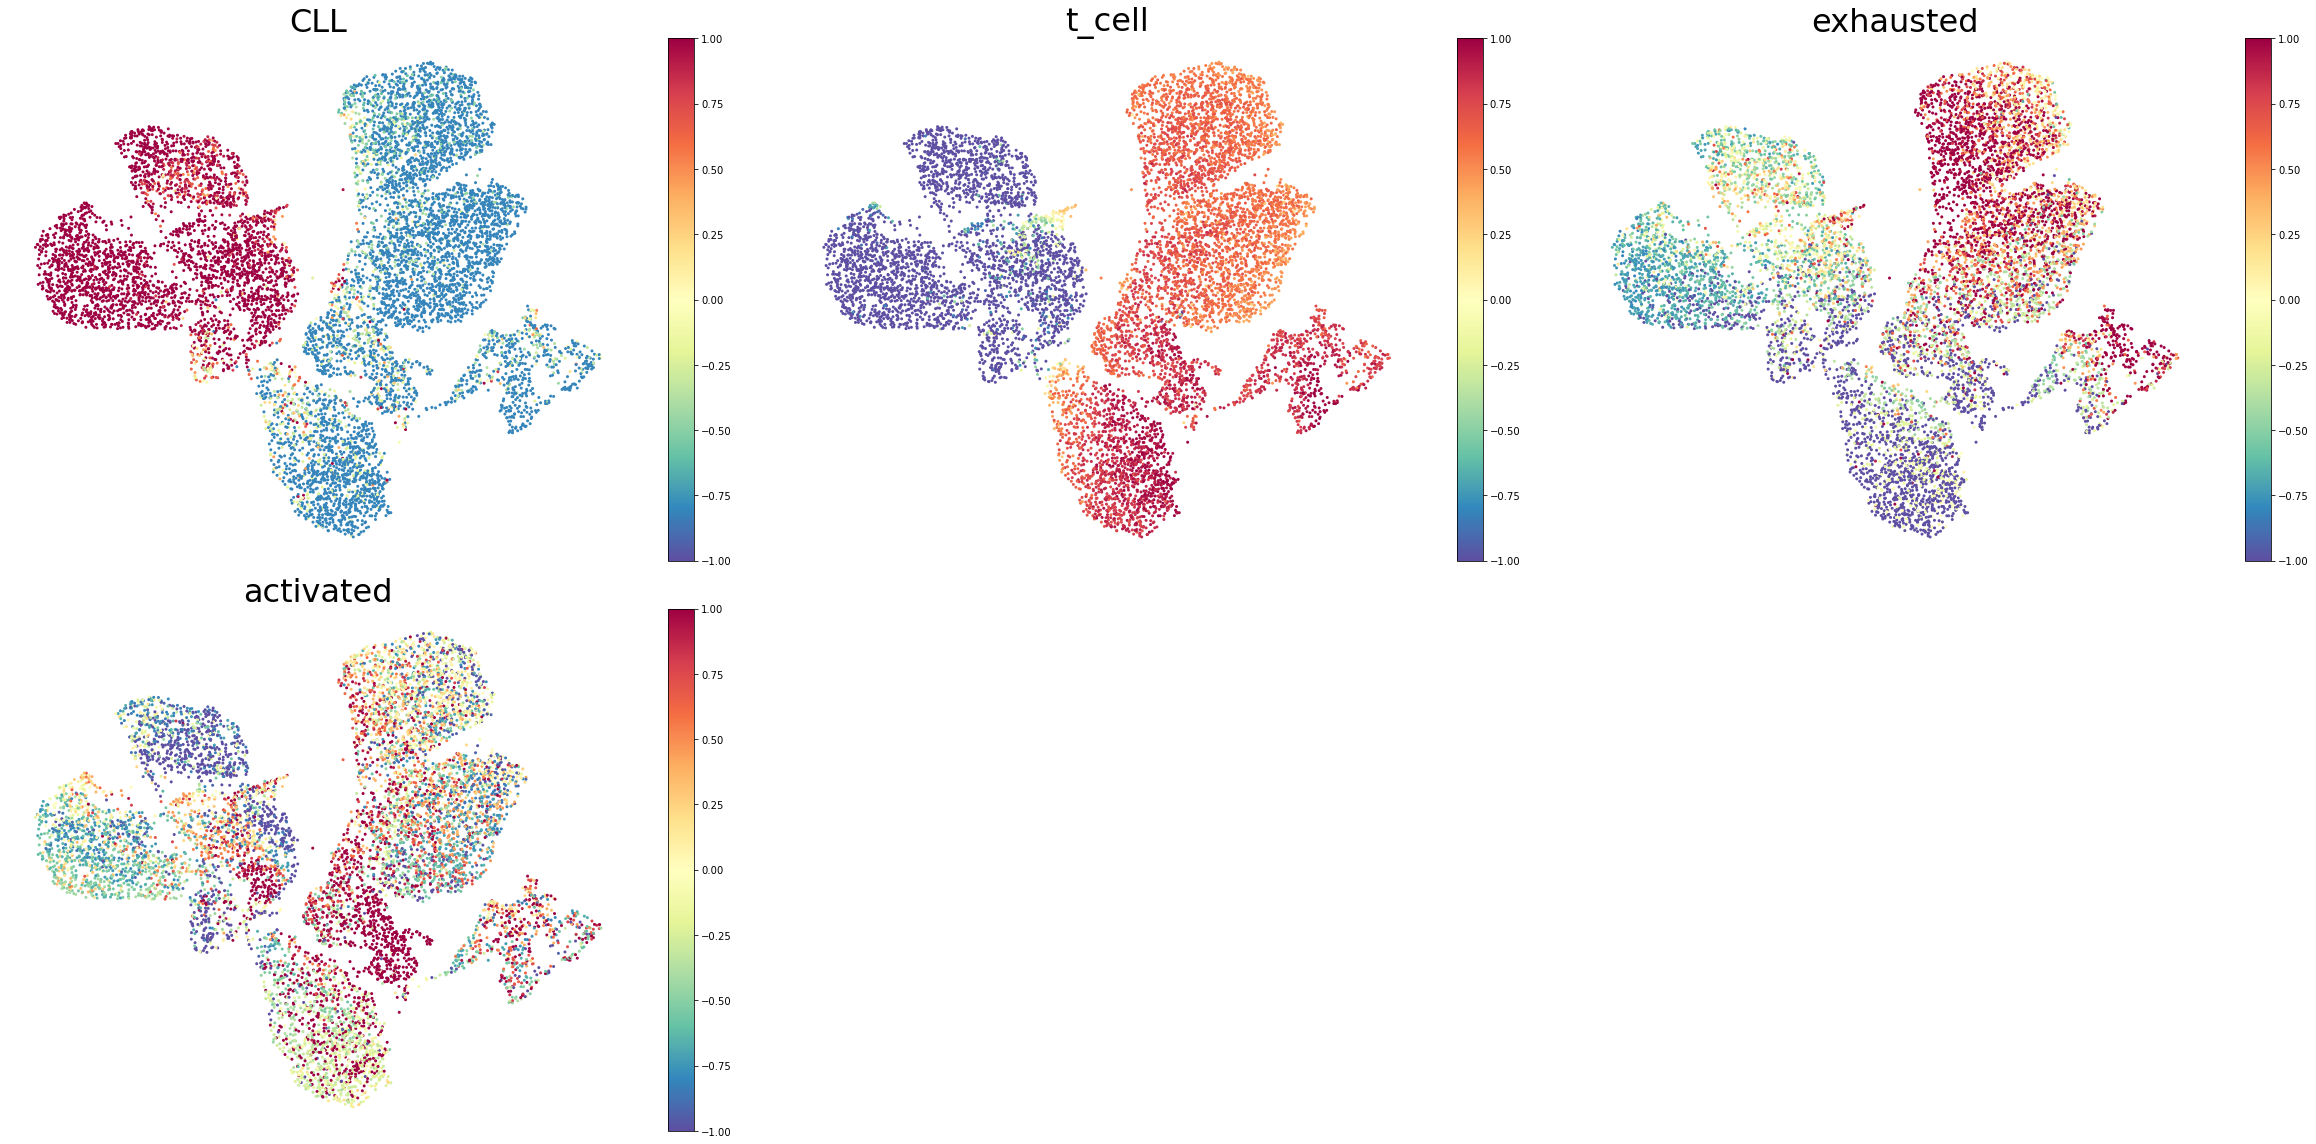

In [40]:
def plot_expression(dictionary, umap_, subset = None, zscore_ = False, fig_size = [11,8]):   
    n = len(dictionary); max_cols = 3
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    fig = plt.figure(figsize=[fig_size[0]* ncols, fig_size[1]*nrows])
    i = 0
    cmap = plt.cm.Spectral_r
        
    for sample in dictionary:
#         print(sample)
        ax = fig.add_subplot(nrows, ncols, i+1)
        c=dictionary[sample]
        umap_["c"] = c
        if subset is None:
            umap_subset = umap_
        else:
            plt.scatter(umap_['x'],umap_['y'],s=1, edgecolors='none', color ="lightgrey")
            umap_subset = umap_.loc[subset.index]
            
        umap_shuffle = umap_subset.sample(frac = 1)
        
        if zscore_ == True:
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=9,vmin =-1, vmax = 1, edgecolors='none', cmap = cmap,  c=zscore(umap_shuffle['c']))
        else: 
            plot = ax.scatter(umap_shuffle['x'],umap_shuffle['y'],s=9, edgecolors='none', cmap = cmap,  c=umap_shuffle['c'])
        fig.colorbar(plot,ax=ax)
        ax.set_title(sample, fontsize = 32)
        ax.set_axis_off()
        i += 1
    fig.tight_layout()
#     plt.savefig('CLLvsT_expC.eps',format = 'eps')
    plt.show()
    return


plot_expression(celltype_counts,umap_, zscore_ = True)

In [10]:
unfiltered = unfiltered.loc[high]

In [11]:
df_genes.head()

CD19     CD79A      CD3E      CD8A     TIGIT     PDCD1     TGFB1  \
0 -2.302585 -2.302585  1.281874 -1.498540 -2.302585 -2.049330 -2.055801   
1 -1.548564 -0.187478 -1.685052 -2.302585 -2.177588 -2.220986 -1.569410   
3 -2.285399 -1.980387  1.558844 -1.825702 -2.191390 -2.299218 -1.585060   
6 -2.165697 -1.988923  1.122973 -1.470586 -1.651446 -2.067521 -1.108672   
7 -1.552997  0.931764 -0.805003 -2.302585 -2.302585 -2.302585 -2.052735   

       LAG3      CD69      CD27      CD28  
0 -0.766192 -2.051085 -0.514575 -2.302585  
1 -2.302585 -1.922745 -1.132485 -2.302585  
3 -2.248808 -1.738457  0.442980 -1.916019  
6 -0.841805 -1.395977  0.004325 -1.486556  
7 -2.302585 -1.547292 -0.744233 -2.040640

In [38]:
cluster_z = pd.DataFrame()
for gene in df_genes.columns:
    cluster_z[gene] = zscore(df_genes[gene])
# cluster_z = cluster_z.transpose()
cluster_z.index = df_genes.index

In [39]:
cluster_z

CD19     CD79A      CD3E      CD8A     TIGIT     PDCD1     TGFB1  \
3  -0.836497 -0.722674  0.924571  0.159123 -0.816876 -1.078453 -1.221067   
9  -0.835385 -0.928560  0.678639 -0.090209  0.611987  1.392832  0.193964   
10  1.023721  1.539192 -1.255843 -1.041840 -1.039493 -0.757440  0.088134   
12 -0.786681 -0.632179  0.778905  0.366955 -0.140738 -0.082071 -1.720135   
15 -0.814606 -0.880825  0.786608  0.718199  0.785757  2.231088  1.491112   
17  1.373869  1.548361 -1.027190 -1.001737 -0.700269 -0.231743  0.220175   
22  1.213211  0.674259 -1.300952 -1.056459 -1.166708 -0.347979 -0.717414   
23  1.270581  0.980392 -1.292507 -1.046653 -0.012402 -0.812012  1.648639   
26 -0.754094 -0.709287  0.800855  2.014812  2.315614  0.319980  0.011032   
28 -0.854119 -0.868678  0.906913  0.977810  0.163129 -0.634201  0.005560   

        LAG3      CD69      CD27      CD28  
3  -0.789614 -0.461372  1.662432 -0.180453  
9   1.058224 -0.744883  0.016804  1.049500  
10 -0.850299 -0.688214  0.559461 -1.168371  
12 -0.144609  2.699854  1.006721  0.575941  
15  1.674453 -0.665115  0.040989  1.104474  
17 -0.746176  0.415905  0.008792 -1.002825  
22 -0.845174  0.066880 -2.269665 -1.181162  
23 -0.832790 -0.896254 -0.861283 -1.163177  
26  1.647678  0.203738 -0.058479  1.345544  
28 -0.171694  0.069461 -0.105772  0.620528

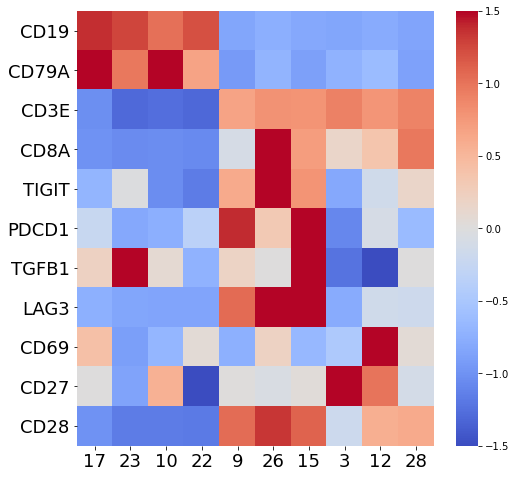

In [41]:
cluster_order =[17,23,10,22,9,26,15,3,12,28]


cluster_CD8 = [19,28]
cluster_CLL_cells = [1,7,8,10,16,17,22,23,24]
cluster_activated = [3,12,14]
cluster_exhausted = [0,6,9,11,15,21,26]




cluster_z = cluster_z.loc[cluster_order]

plt.figure(figsize = (8,8))
sns.heatmap(cluster_z.transpose(),vmin = -1.5, vmax = 1.5,xticklabels=True, cmap = 'coolwarm', yticklabels=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(rotation = 0)
plt.savefig('heatmap_cart_genes.eps', format = 'eps')
plt.show()



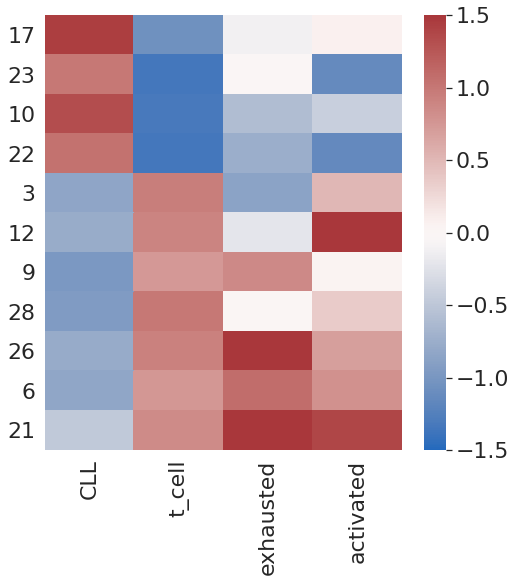

In [21]:
# unfiltered = unfiltered.reindex(rows)
df_z = pd.DataFrame(zscore(unfiltered,axis = 0), index = ind, columns = unfiltered.columns)
df_z = df_z.loc[high]
# plt.figure(figsize = (12,10))
sns.set(font_scale = 2)
# sns.clustermap(unfiltered,xticklabels=True, cmap = 'vlag', yticklabels=True)
cluster_order = [17,23,10,22,3,12,9,28,26,6,21]
column_order = ['CLL','t_cell','exhausted','activated']
unfiltered = unfiltered.loc[cluster_order, column_order]
plt.figure(figsize = (8,8))
sns.heatmap(unfiltered,vmin = -1.5, vmax = 1.5,xticklabels=True, cmap = 'vlag', yticklabels=True)
plt.yticks(rotation = 0)
# plt.xticks(rotation = 0)

plt.savefig('heatmap_carT_expC.pdf',format = 'pdf')
# sns.clustermap(df_z,xticklabels=True, cmap = 'vlag', yticklabels=True)

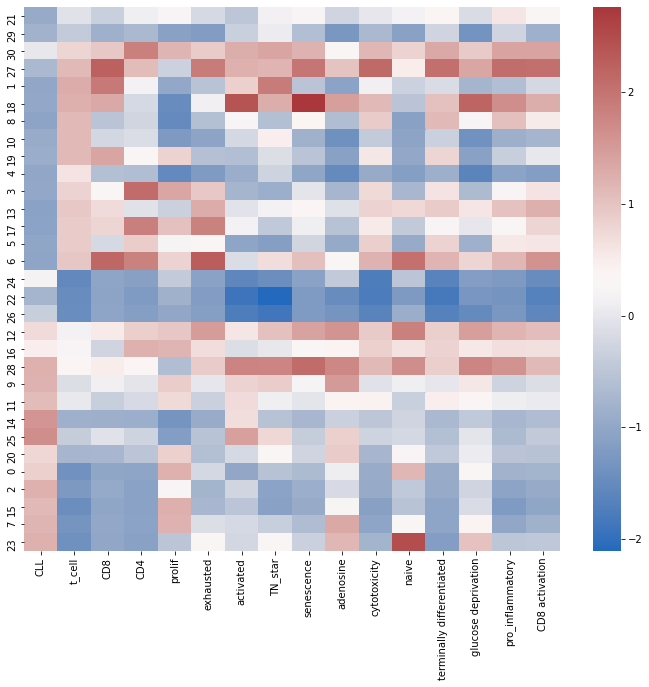

In [83]:
df_z = pd.DataFrame(zscore(unfiltered,axis = 1), index = unfiltered.index, columns = unfiltered.columns)
plt.figure(figsize = (12,10))
sns.heatmap(unfiltered,xticklabels=True, cmap = 'vlag', yticklabels=True)

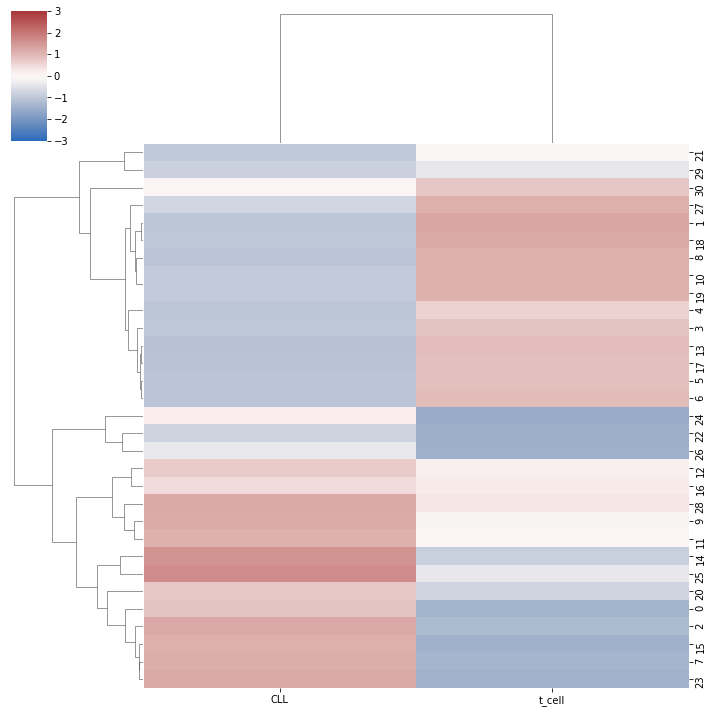

In [65]:
g = sns.clustermap(unfiltered,xticklabels=True, vmin = -3, vmax = 3, cmap = 'vlag', yticklabels=True)
rows = g.dendrogram_row.reordered_ind
# cols = g.dendrogram_col.reordered_ind

In [22]:
umap_

x          y  DATA time  cluster_number
CARC_T8_AAACCTGAGAAGGCCT   6.913898   1.900483  CARC   T8              12
CARC_T9_AAACCTGAGACAAGCC   4.048230  -9.293954  CARC   T9               3
CARC_T6_AAACCTGAGACAATAC   3.215822   0.146794  CARC   T6               3
CARC_T9_AAACCTGAGCCATCGC  -2.713778   4.231982  CARC   T9              10
CARC_T2_AAACCTGAGGTAGCTG  -0.492172   9.216688  CARC   T2              17
...                             ...        ...   ...  ...             ...
CARC_T9_TTTGTCATCATGTAGC   2.877154   3.228731  CARC   T9              17
CARC_T9_TTTGTCATCGACGGAA   9.211007  16.676344  CARC   T9              15
CARC_T9_TTTGTCATCGGCTTGG  11.221828  17.384693  CARC   T9              15
CARC_T7_TTTGTCATCGTGGGAA   9.471777   3.279388  CARC   T7               9
CARC_T8_TTTGTCATCTTCATGT  14.057061   8.251666  CARC   T8               9

[9240 rows x 5 columns]

# SETTING METACLUSTER ASSIGNMENTS

In [10]:
umap_.head()

x         y  DATA time  cluster_number
CARC_T8_AAACCTGAGAAGGCCT  6.913898  1.900483  CARC   T8              12
CARC_T9_AAACCTGAGACAAGCC  4.048230 -9.293954  CARC   T9               3
CARC_T6_AAACCTGAGACAATAC  3.215822  0.146794  CARC   T6               3
CARC_T9_AAACCTGAGCCATCGC -2.713778  4.231982  CARC   T9              10
CARC_T2_AAACCTGAGGTAGCTG -0.492172  9.216688  CARC   T2              17

In [20]:
cluster_CD8 = [19,28] #yellows
cluster_CLL_cells = [1,7,8,10,16,17,22,23,24] #blues
cluster_activated = [3,12,14] #greens
cluster_exhausted = [0,6,9,11,15,21,26] #reds
all_clusters = np.unique(umap_['cluster_number'])
color_dict = OrderedDict()
color_dict[19] = 'gold'
color_dict[28] = 'goldenrod'

color_dict[1] = 'dodgerblue'
color_dict[7] = 'lightskyblue'
color_dict[8] = 'darkturquoise'
color_dict[10] = 'steelblue'
color_dict[16] = 'royalblue'
color_dict[17] = 'blue'
color_dict[22] = 'navy'
color_dict[23] = 'darkslateblue'
color_dict[24] = 'teal'

color_dict[3] = 'green'
color_dict[12] = 'limegreen'
color_dict[14] = 'lawngreen'

color_dict[0] = 'crimson'
color_dict[6] = 'magenta'
color_dict[9] = 'hotpink'
color_dict[11] = 'orangered'
color_dict[15] = 'red'
color_dict[21] = 'salmon'
color_dict[26] = 'deeppink'


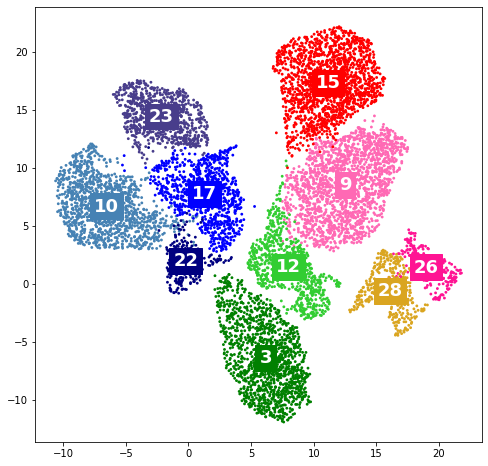

In [27]:
plt.figure(figsize = (8,8))
for i,cluster in enumerate(all_clusters):
    
    COLOR = color_dict[cluster]
    cells = umap_.index[umap_['cluster_number']==cluster]
    if len(cells)<40: continue
    plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],label = cluster,
            s=8, edgecolors='none',color=COLOR)
    plt.annotate(cluster, 
             umap_.loc[cells,['x','y']].mean(),
             horizontalalignment='center',
             verticalalignment='center',
             size=18, weight = 'bold',
             color='white',
             backgroundcolor=COLOR) 
# plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', markerscale = 6)
plt.savefig('umap_expc_CLUSTERS.eps', format = 'eps')
# plt.title(string)
plt.show()

In [24]:
metacluster = []
for cell in umap_.index:
    original_cluster = data_df.loc[cell,'cluster_number']
    if original_cluster in cluster_CLL_cells:
        metacluster.append(0)
    elif original_cluster in cluster_CD8:
        metacluster.append(1)
    elif original_cluster in cluster_activated:
        metacluster.append(2)
    elif original_cluster in cluster_exhausted:
        metacluster.append(3)
    else:
        metacluster.append(np.nan)
        
data_df['metacluster'] = metacluster
umap_['metacluster'] = metacluster

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


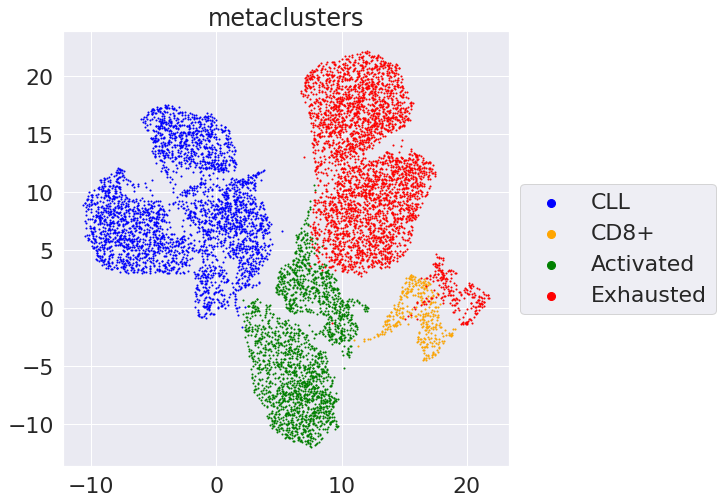

In [30]:
color_ = ['blue','orange','green','red']
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize = (8,8))
plt.scatter(umap_.loc[:,'x'],umap_.loc[:,'y'], s = 1, color = 'lightgrey')


cells = umap_[umap_['metacluster'] == 0].index
plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, color = color_[0], label = 'CLL')

cells = umap_[umap_['metacluster'] == 1].index
plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, color = color_[1], label = 'CD8+')

cells = umap_[umap_['metacluster'] == 2].index
plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, color = color_[2], label = 'Activated')

cells = umap_[umap_['metacluster'] == 3].index
plt.scatter(umap_.loc[cells,'x'],umap_.loc[cells,'y'], s = 1, color = color_[3], label = 'Exhausted')

plt.title('metaclusters')
plt.legend(markerscale = 8, bbox_to_anchor = (1,0.5), loc = 'center left')
plt.savefig('metacluster_assignment.eps', format = 'eps')
plt.show()

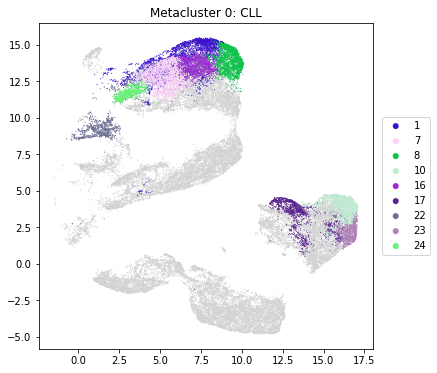

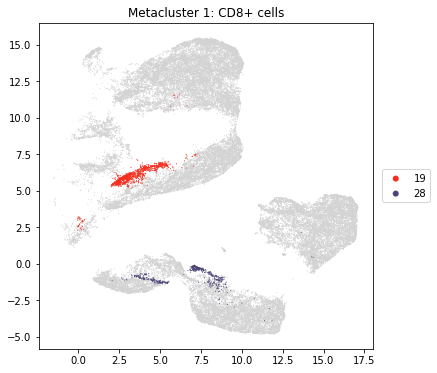

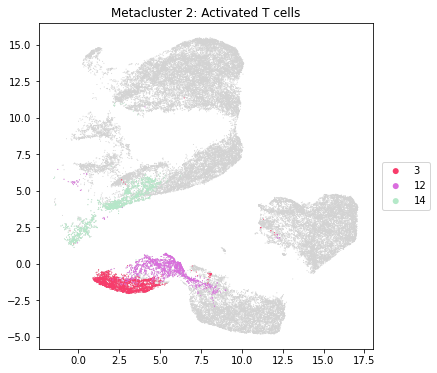

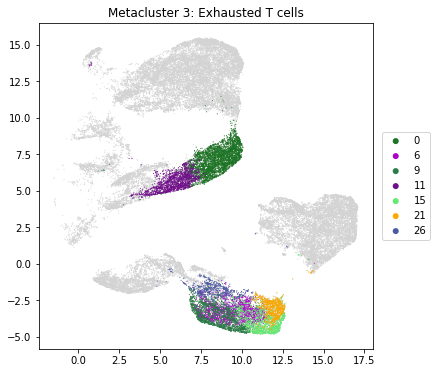

In [87]:
n_cluster_knn = np.amax(data_df['cluster_number'])
umap_['cluster_number'] = data_df['cluster_number']
plot_someclusters(cluster_CLL_cells, umap_, string = "Metacluster 0: CLL")
plot_someclusters(cluster_CD8, umap_,"Metacluster 1: CD8+ cells")
plot_someclusters(cluster_activated, umap_,"Metacluster 2: Activated T cells")
plot_someclusters(cluster_exhausted, umap_,"Metacluster 3: Exhausted T cells")

In [88]:
# samples = []
# for cell in umap_.index:
#     samp = cell.split("_")[0]+"_"+cell.split("_")[1]
#     if samp not in samples:
#         samples.append(samp)

In [102]:
# umap_noNAN = umap_.dropna(axis = 0, how = 'any')
# umap_noNAN
# umap_.to_pickle('CAR_T_umap_revised.pkl')

x          y         c  cluster_number  \
CARA_T1_AAACCTGAGCGAAGGG   6.289377  13.234041 -2.302585               7   
CARA_T9_AAACCTGAGCGGATCA   6.609953  14.180170 -2.302585               1   
CARA_T0_AAACCTGAGCTGCAAG   4.107403   6.505929  1.032986              19   
CARA_T7_AAACCTGAGGATTCGG   3.964390   4.341495  1.606580              14   
CARA_T9_AAACCTGAGTGAATTG  -0.372394   2.730860 -0.558537               1   
...                             ...        ...       ...             ...   
CARD_T8_TTTGTCAGTTACGACT   9.645974  -3.386598  1.383331               6   
CARD_T7_TTTGTCATCAGCTCTC   9.424454  -3.666434  0.990013               6   
CARD_T7_TTTGTCATCCGTTGCT   5.692782   0.139906  1.607675              12   
CARD_T6_TTTGTCATCCTCGCAT  10.336457  -1.840803  1.354969              26   
CARD_T7_TTTGTCATCGTAGGAG  15.998152   3.770051 -2.302585              10   

                          metacluster  DATA time  
CARA_T1_AAACCTGAGCGAAGGG          0.0  CARA   T1  
CARA_T9_AAACCTGAGCGGATCA          0.0  CARA   T9  
CARA_T0_AAACCTGAGCTGCAAG          1.0  CARA   T0  
CARA_T7_AAACCTGAGGATTCGG          2.0  CARA   T7  
CARA_T9_AAACCTGAGTGAATTG          0.0  CARA   T9  
...                               ...   ...  ...  
CARD_T8_TTTGTCAGTTACGACT          3.0  CARD   T8  
CARD_T7_TTTGTCATCAGCTCTC          3.0  CARD   T7  
CARD_T7_TTTGTCATCCGTTGCT          2.0  CARD   T7  
CARD_T6_TTTGTCATCCTCGCAT          3.0  CARD   T6  
CARD_T7_TTTGTCATCGTAGGAG          0.0  CARD   T7  

[35887 rows x 7 columns]

# SAVING RATIO FILES FOR EACH EXPERIMENT INDIVIDUALLY

In [139]:
data_arr = np.unique(umap_noNAN['DATA'])
samples = np.unique(umap_noNAN['time'])
data_dict = OrderedDict()
for data in data_arr:
    df = umap_noNAN[umap_noNAN['DATA']==data]
    
    ratios = OrderedDict()
    
    for samp in samples:
        ratios[samp] = np.zeros(int(np.amax(umap_['metacluster']))+2)

    for cell in df.index:
        samp = df.loc[cell,'time']
        metacluster_assignment = df.loc[cell,'metacluster']
        ratios[samp][int(metacluster_assignment)] += 1
        ratios[samp][-1] += 1
        
    data_dict[data] = ratios


In [140]:
for data in data_arr:
    ratios = data_dict[data]
    total_cells = []
    for key in ratios:
        total = ratios[key][-1]
        total_cells.append(total)
        ratios[key] = ratios[key]/total

    ratios_df = pd.DataFrame.from_dict(ratios)
    ratios_df = ratios_df.transpose()
    ratios_df = ratios_df.drop(columns = [4])
    ratios_df['total_cells_per_sample'] = total_cells
    file = data+"_ratios.pkl"
    print(file)
    ratios_df.to_pickle(file)

CARA_ratios.pkl
CARB_14_ratios.pkl
CARB_41_ratios.pkl
CARC_ratios.pkl
CARD_ratios.pkl


<ipython-input-140-204ce6413b1e>:7: RuntimeWarning: invalid value encountered in true_divide
  ratios[key] = ratios[key]/total


In [141]:
A = pd.read_pickle('CARA_ratios.pkl')
B_14 = pd.read_pickle('CARB_14_ratios.pkl')
B_41 = pd.read_pickle('CARB_41_ratios.pkl')
C = pd.read_pickle('CARC_ratios.pkl')
D = pd.read_pickle('CARD_ratios.pkl')

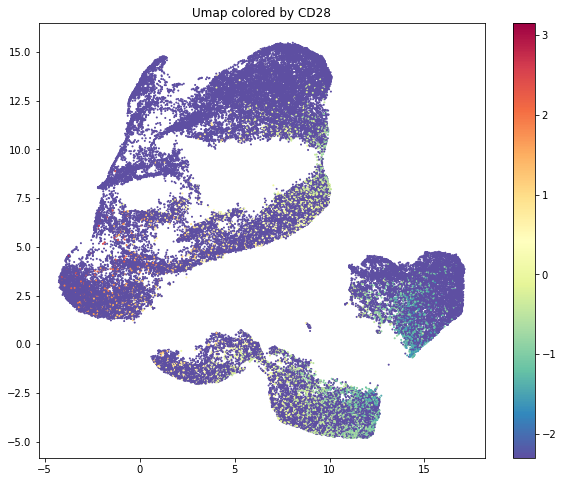

In [12]:
DF = umap_
plt.figure(figsize = [10,8])
plt.scatter(DF['x'],DF['y'], s = 1,cmap = plt.cm.Spectral_r, c = data_df['CD28'])
plt.title("Umap colored by CD28")
plt.colorbar()
plt.show()

In [54]:
umap_['cluster_number'] = data_df['cluster_number']

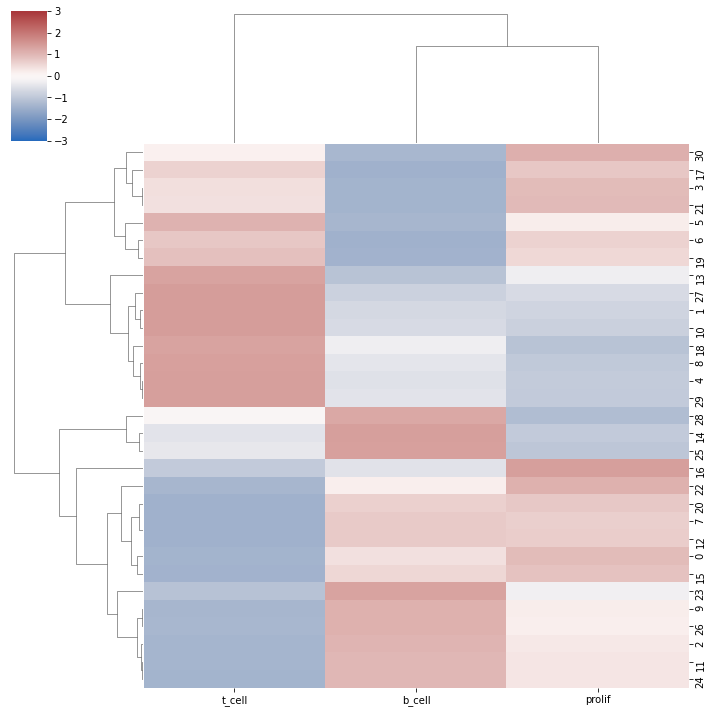

In [55]:
DF = data_df

DF["cluster_number"] = umap_["cluster_number"]
n_cluster_knn = np.amax(DF["cluster_number"])
#getting average gene expression for each cluster

df_cluster = pd.DataFrame()
for cluster in range(n_cluster_knn + 1):
    total_cells = len(DF[DF['cluster_number'] == cluster])
    df_cluster[cluster] = DF[DF['cluster_number'] == cluster].sum()
    df_cluster[cluster] = df_cluster[cluster]/total_cells
    
df_cluster = df_cluster.transpose()
df_cluster.head()

df_cluster = df_cluster.drop(columns = ["cluster_number"])   
df_cluster = df_cluster.dropna()
ind = df_cluster.index
#now getting average signature expression for each cluster 
cell_counts = OrderedDict()
for key in cell_dict:
    gene_set = cell_dict[key]
    counts = np.zeros(len(df_cluster))
    length = len(gene_set)
    for gene in gene_set:
        if gene not in df_cluster.columns:
            length -= 1
            continue
        gene_array = df_cluster[gene]
        counts = np.add(counts,gene_array)
    counts = np.divide(counts,length)
    cell_counts[key] = counts

#creating dataframe where rows are clusters and columns are average expression for each of the cell types
celltypes = np.array(list(cell_counts.keys()))
unfiltered = pd.DataFrame()
for i in cell_counts:
    temp = zscore(cell_counts[i])
    unfiltered[i] = temp
df_z = pd.DataFrame(zscore(unfiltered,axis = 1), index = ind, columns = unfiltered.columns)
sns.clustermap(df_z,xticklabels=True, vmin = -3, vmax = 3, cmap = 'vlag', yticklabels=True)

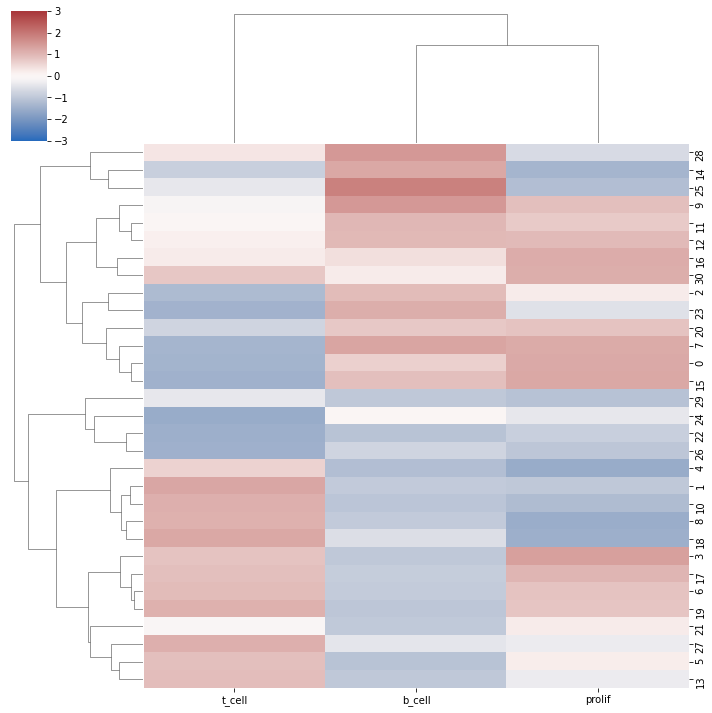

In [56]:
sns.clustermap(unfiltered,xticklabels=True, vmin = -3, vmax = 3, cmap = 'vlag', yticklabels=True)

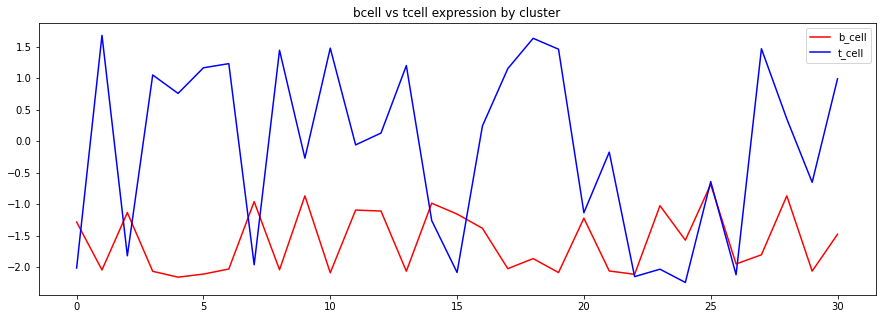

In [78]:
X = np.arange(n_cluster_knn + 1)
plt.figure(figsize = [15,5])
plt.plot(X,cell_counts['b_cell'],label = 'b_cell', color = 'r')
plt.plot(X,cell_counts['t_cell'],label = 't_cell', color = 'b')
plt.legend()
plt.title("bcell vs tcell expression by cluster")
plt.show()

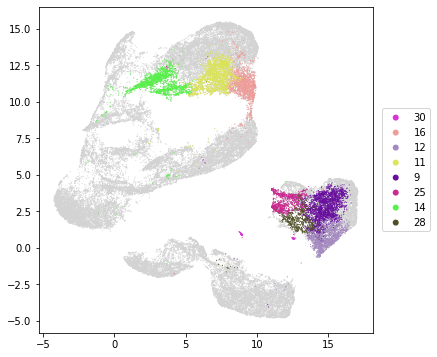

In [81]:
interacting = [30,16,12,11,9,25,14,28]
plot_someclusters(interacting, umap_)

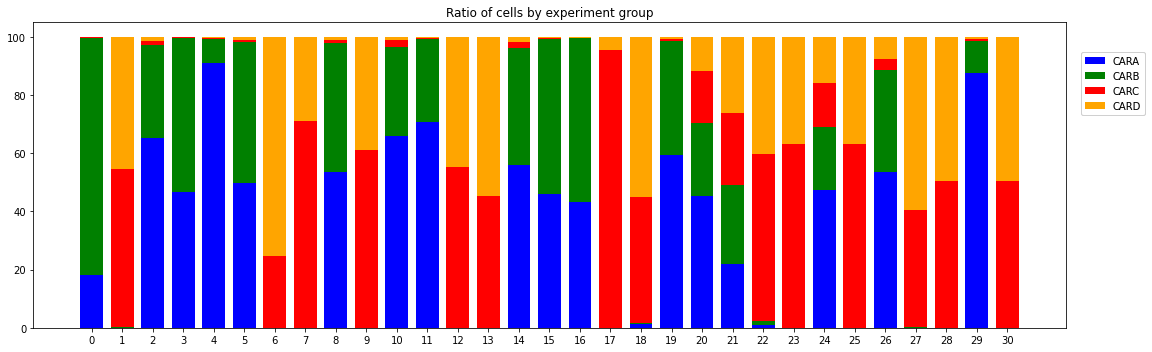

In [84]:
n_cluster_knn = np.amax(data_df["cluster_number"])
a = np.arange(n_cluster_knn + 1)

SAMPLE = experiments
sample_dict=OrderedDict()


sample_dict['CARA'] = np.zeros(n_cluster_knn+1)
sample_dict['CARB'] = np.zeros(n_cluster_knn+1)
sample_dict['CARC'] = np.zeros(n_cluster_knn+1)
sample_dict['CARD'] = np.zeros(n_cluster_knn+1)

total_cellcount = OrderedDict()
for sample in SAMPLE: # for each patient
    total_cellcount[sample] = 0
    for i in range(len(data_df)): #for each cell
        cell_id =  data_df.index[i]
        if sample in cell_id: 
            cluster = data_df["cluster_number"][i]
            array = sample_dict[sample]
            array[cluster] += 1
            sample_dict[sample] = array
            total_cellcount[sample] += 1
            

snum = sum(sample_dict.values())
# # normalization
p1 = sample_dict['CARA']/snum *100
p2 = sample_dict['CARB']/snum *100
p3 = sample_dict['CARC']/snum *100
p4 = sample_dict['CARD']/snum *100


order = pd.DataFrame({'A':p1,'B':p2,'C':p3,'D':p4, "cluster_number":np.arange(n_cluster_knn+1)})
my_order = order.sort_values(by=["cluster_number"], ascending = True)
my_order = my_order.dropna()

my_order.index = np.arange(len(my_order))

labels = [str(i) for i in my_order["cluster_number"]] 


fig, ax = plt.subplots(figsize=[15, 5])
width = 0.75       # the width of the bars: can also be len(x) sequence
ax.bar(labels, my_order["A"], width, label=SAMPLE[0], color = col_arr[0])
ax.bar(labels, my_order['B'], width, bottom=my_order['A'], label=SAMPLE[1], color = col_arr[1])
ax.bar(labels, my_order['C'], width, bottom=my_order['A']+my_order['B'], label=SAMPLE[2], color = col_arr[2])
ax.bar(labels, my_order['D'], width, bottom=my_order['A']+my_order['B']+my_order['C'], label=SAMPLE[3], color = col_arr[3])

ax.set_title('Ratio of cells by experiment group')

leg1 = ax.legend(bbox_to_anchor=(1.01, 0.8), loc='center left')
ax.add_artist(leg1)
fig.tight_layout()
plt.show()



In [85]:
time

['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']

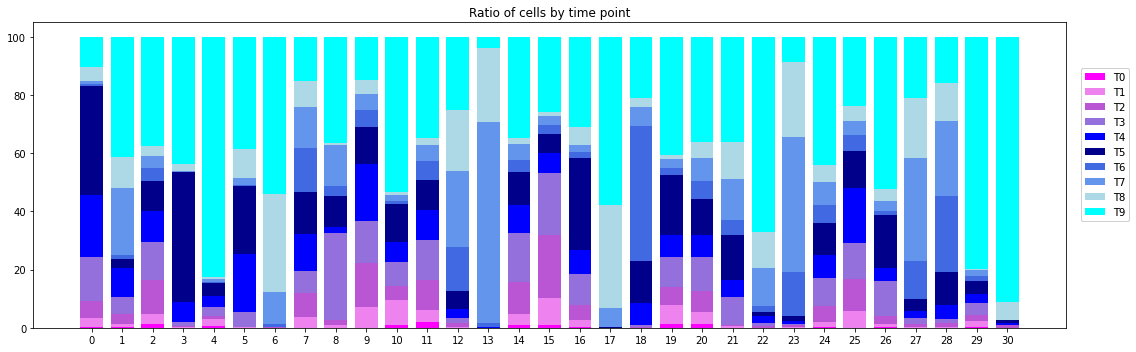

In [90]:
n_cluster_knn = np.amax(data_df["cluster_number"])
a = np.arange(n_cluster_knn + 1)

SAMPLE = time
sample_dict=OrderedDict()


sample_dict[time[0]] = np.zeros(n_cluster_knn+1)
sample_dict[time[1]] = np.zeros(n_cluster_knn+1)
sample_dict[time[2]] = np.zeros(n_cluster_knn+1)
sample_dict[time[3]] = np.zeros(n_cluster_knn+1)
sample_dict[time[4]] = np.zeros(n_cluster_knn+1)
sample_dict[time[5]] = np.zeros(n_cluster_knn+1)
sample_dict[time[6]] = np.zeros(n_cluster_knn+1)
sample_dict[time[7]] = np.zeros(n_cluster_knn+1)
sample_dict[time[8]] = np.zeros(n_cluster_knn+1)
sample_dict[time[9]] = np.zeros(n_cluster_knn+1)

total_cellcount = OrderedDict()
for sample in SAMPLE: # for each patient
    total_cellcount[sample] = 0
    for i in range(len(data_df)): #for each cell
        cell_id =  data_df.index[i]
        if sample in cell_id: 
            cluster = data_df["cluster_number"][i]
            array = sample_dict[sample]
            array[cluster] += 1
            sample_dict[sample] = array
            total_cellcount[sample] += 1
            

snum = sum(sample_dict.values())
# # normalization
p1 = sample_dict[time[0]]/snum *100
p2 = sample_dict[time[1]]/snum *100
p3 = sample_dict[time[2]]/snum *100
p4 = sample_dict[time[3]]/snum *100
p5 = sample_dict[time[4]]/snum *100
p6 = sample_dict[time[5]]/snum *100
p7 = sample_dict[time[6]]/snum *100
p8 = sample_dict[time[7]]/snum *100
p9 = sample_dict[time[8]]/snum *100
p10 = sample_dict[time[9]]/snum *100


order = pd.DataFrame({time[0]:p1,time[1]:p2,time[2]:p3,time[3]:p4,time[4]:p5,time[5]:p6,
                      time[6]:p7,time[7]:p8,time[8]:p9,time[9]:p10, "cluster_number":np.arange(n_cluster_knn+1)})
my_order = order.sort_values(by=["cluster_number"], ascending = True)
my_order = my_order.dropna()

my_order.index = np.arange(len(my_order))

labels = [str(i) for i in my_order["cluster_number"]] 


fig, ax = plt.subplots(figsize=[15, 5])
width = 0.75       # the width of the bars: can also be len(x) sequence
ax.bar(labels, my_order[time[0]], width, label=SAMPLE[0], color = color_set[0])
ax.bar(labels, my_order[time[1]], width, bottom=my_order[time[0]], label=SAMPLE[1], color = color_set[1])
ax.bar(labels, my_order[time[2]], width, bottom=my_order[time[0]]+my_order[time[1]], label=SAMPLE[2], color = color_set[2])
ax.bar(labels, my_order[time[3]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]], label=SAMPLE[3], color = color_set[3])
ax.bar(labels, my_order[time[4]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]], label=SAMPLE[4], color = color_set[4])
ax.bar(labels, my_order[time[5]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]]+my_order[time[4]], label=SAMPLE[5], color = color_set[5])
ax.bar(labels, my_order[time[6]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]]+my_order[time[4]]+my_order[time[5]], label=SAMPLE[6], color = color_set[6])
ax.bar(labels, my_order[time[7]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]]+my_order[time[4]]+my_order[time[5]]+my_order[time[6]], label=SAMPLE[7], color = color_set[7])
ax.bar(labels, my_order[time[8]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]]+my_order[time[4]]+my_order[time[5]]+my_order[time[6]]+my_order[time[7]], label=SAMPLE[8], color = color_set[8])
ax.bar(labels, my_order[time[9]], width, bottom=my_order[time[0]]+my_order[time[1]]+my_order[time[2]]+my_order[time[3]]+my_order[time[4]]+my_order[time[5]]+my_order[time[6]]+my_order[time[7]]+my_order[time[8]], label=SAMPLE[9], color = color_set[9])
ax.set_title('Ratio of cells by time point')

leg1 = ax.legend(bbox_to_anchor=(1.01, 0.6), loc='center left')
ax.add_artist(leg1)
fig.tight_layout()
plt.show()

In [98]:
 #sample_info is a dictionary that holds the number of cells belonging to each sample
sample_info = OrderedDict()
DF = umap_

for value in experiments:
    newcell = DF.index[DF.index.str.contains(value)]
    sample_info[value] = len(newcell)


for value in experiments:
    temp = sample_info[value]
    sample_info[value] = np.zeros(n_cluster_knn + 2)
    sample_info[value][0] = temp
print("intitial part done, now counting total cells")


intitial part done, now counting total cells


In [ ]:
for cluster in range(n_cluster_knn + 1) :
    df = DF[DF["cluster_number"] == cluster]
    for value in experiments:
        num = len(df.index[df.index.str.contains(value)])
        sample_info[value][cluster + 1] = num   

In [150]:

# SAMPLE = sample_arr

total_cells = OrderedDict()

# for exp in experiments:
#     for t in time:
#         string = exp+'_'+t
#     df = data_df[data_df.index.str.contains(string)]
#     total_cells[exp][t] = len(df)
    
    
for exp in experiments:
    total_cells[exp] ={time[0]:0,time[1]:0,time[2]:0,time[3]:0,time[4]:0,time[5]:0,
                             time[6]:0,time[7]:0,time[8]:0,time[9]:0}
    for t in time:
        string = exp+'_'+t
        total_cells[exp][t] =  data_df[data_df.index.str.contains(string)].shape[0]

In [117]:
experiments = ['CARA','CARB','CARC','CARD']
col_arr = ["blue", 'green','red','orange']
time = ["T0","T1","T2","T3","T4","T5","T6","T7","T8","T9"]
color_set = ['magenta','violet','mediumorchid','mediumpurple','blue',
             'darkblue','royalblue','cornflowerblue','lightblue','cyan']

In [160]:
cluster_dict = OrderedDict()
for key in X:
    cluster_dict[key] = {experiments[0]:0,experiments[1]:0,experiments[2]:0,experiments[3]:0}
    for exp in experiments:
        cluster_dict[key][exp] = {time[0]:0,time[1]:0,time[2]:0,time[3]:0,time[4]:0,time[5]:0,
                             time[6]:0,time[7]:0,time[8]:0,time[9]:0}
    
for cluster in range(n_cluster_knn+1):
    df = umap_[umap_["cluster_number"] == cluster]
    for cell in df.index:
        e = cell.split("_")[0]
        t = cell.split("_")[1]
        cluster_dict[cluster][e][t] += 1
                


In [167]:
for cluster in range(n_cluster_knn + 1): 
    for t in time:
        for exp in experiments:
            val = cluster_dict[cluster][exp][t]
#             print(cluster, exp, t, cluster_dict[cluster][exp][t], total_cells[exp][t])
            if total_cells[exp][t] != 0: print(val/total_cells[exp][t])
            if total_cells[exp][t] != 0:
                cluster_dict[cluster][exp][t] = val/total_cells[exp][t]
#                 print(cluster_dict[cluster][exp][t])

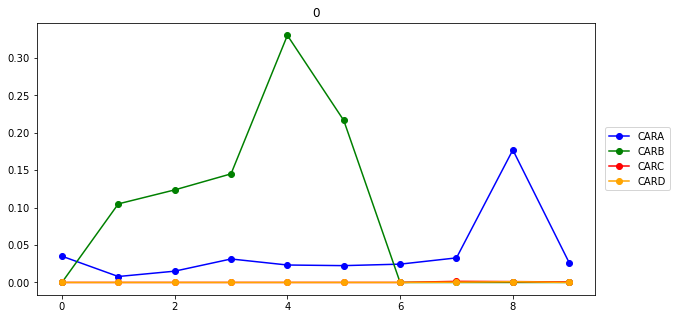

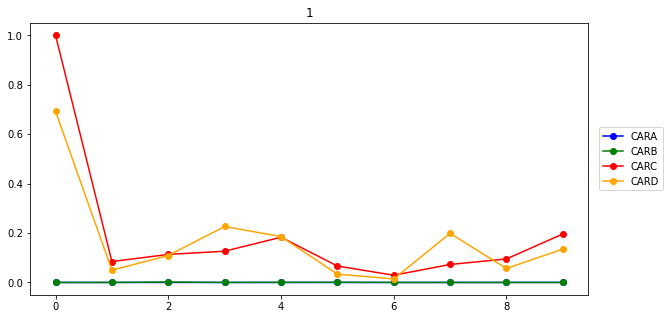

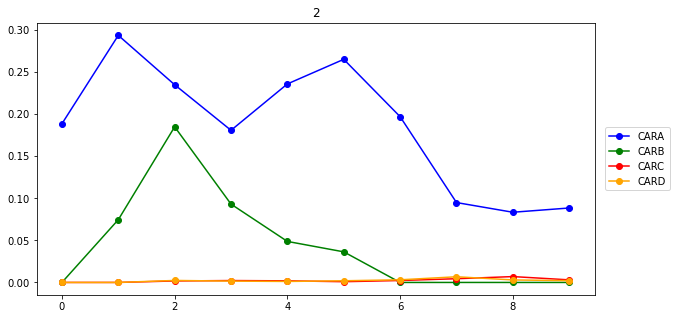

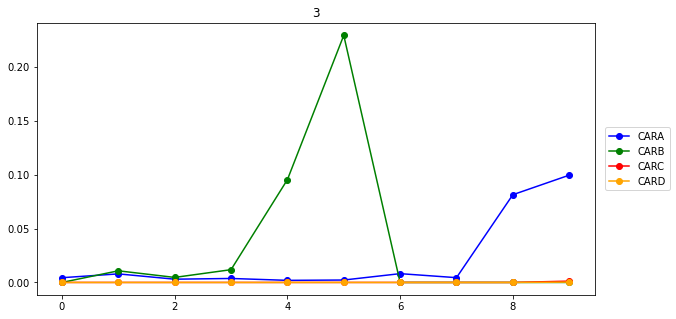

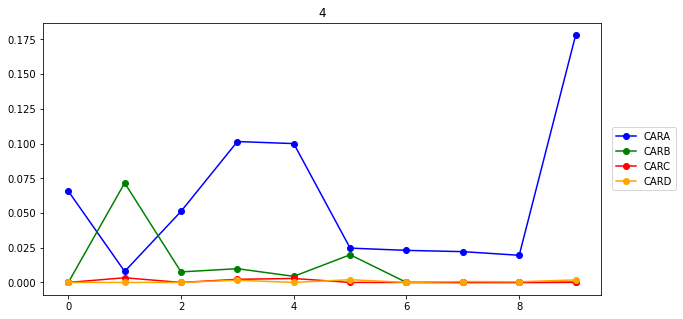

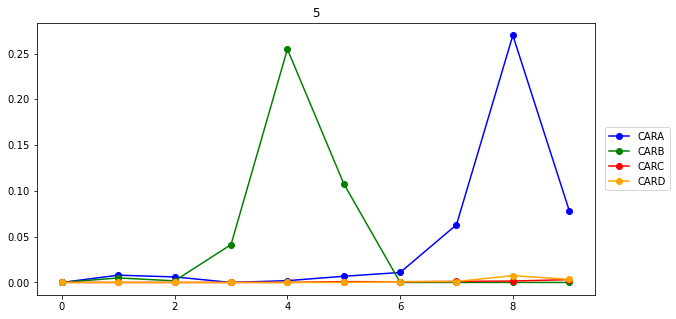

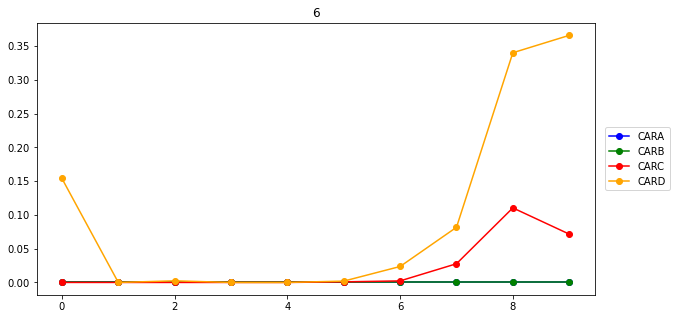

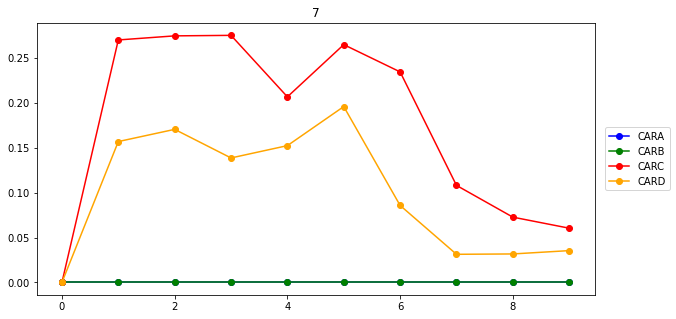

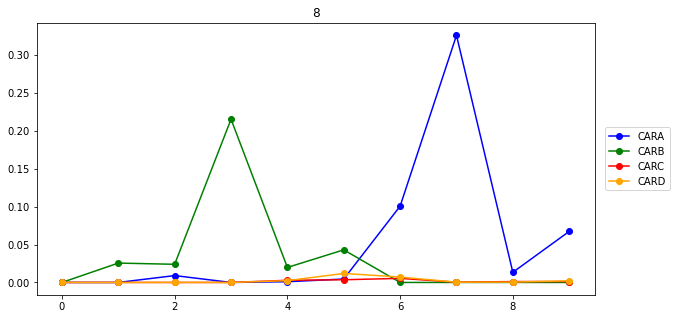

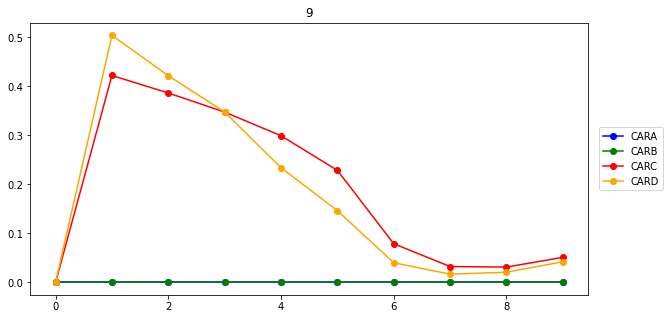

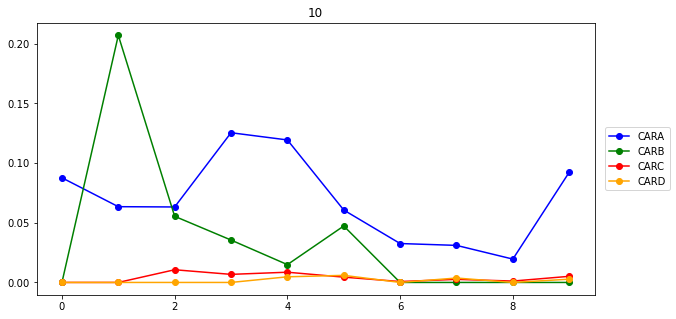

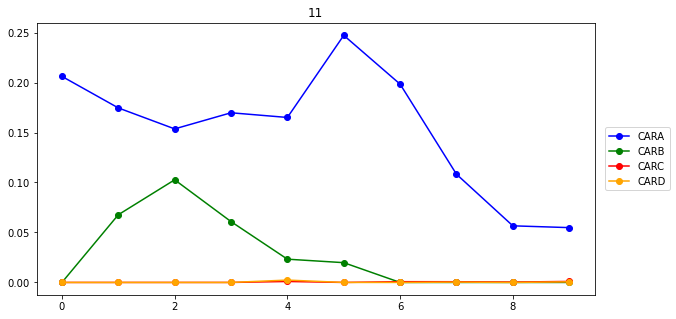

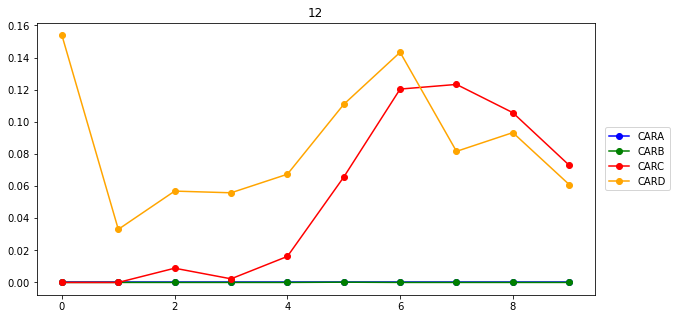

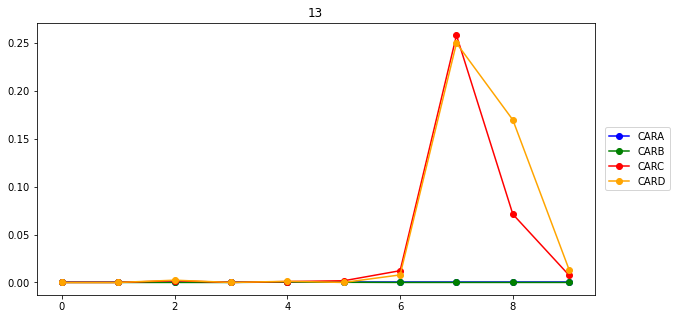

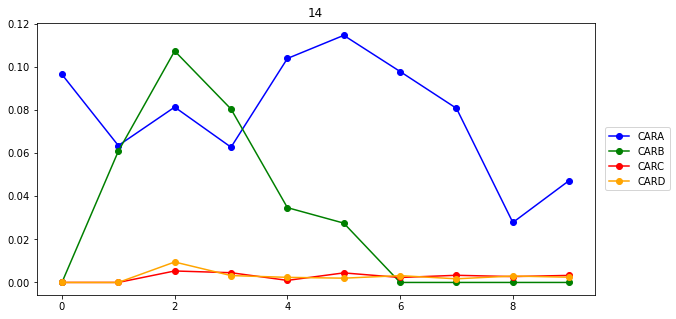

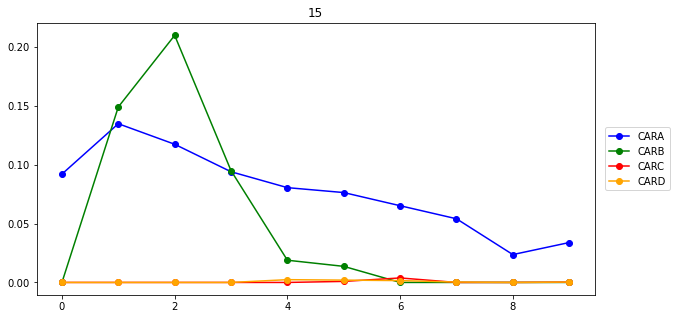

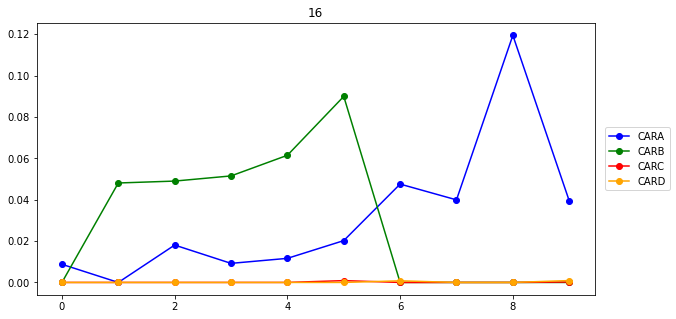

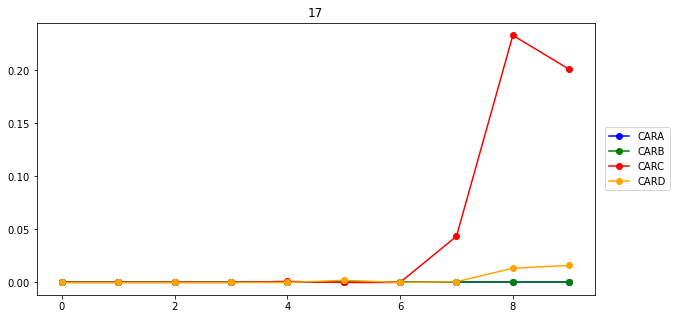

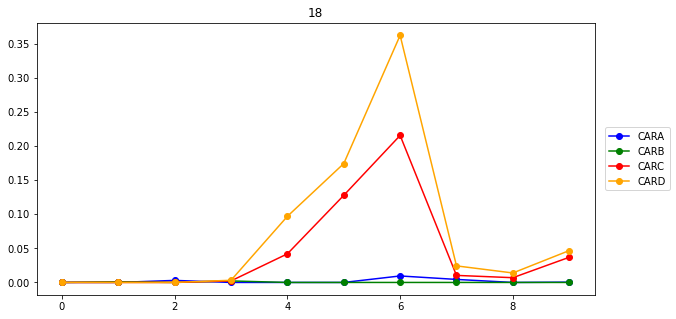

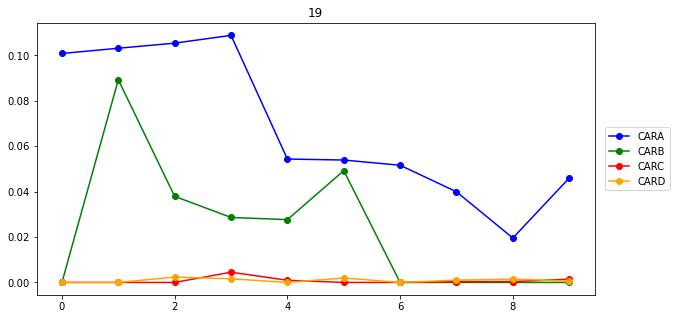

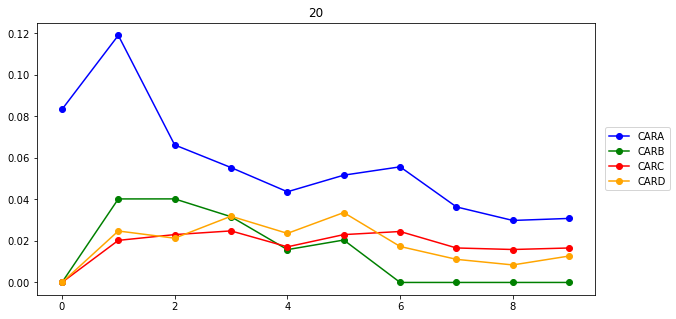

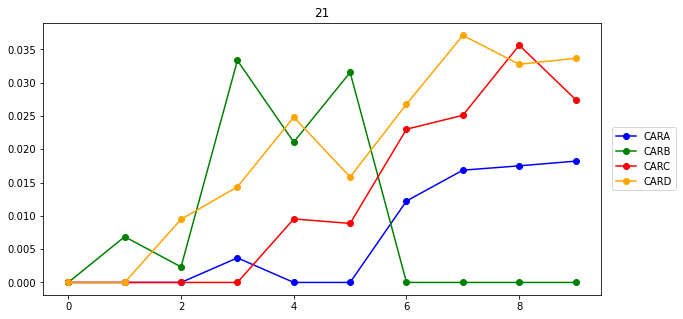

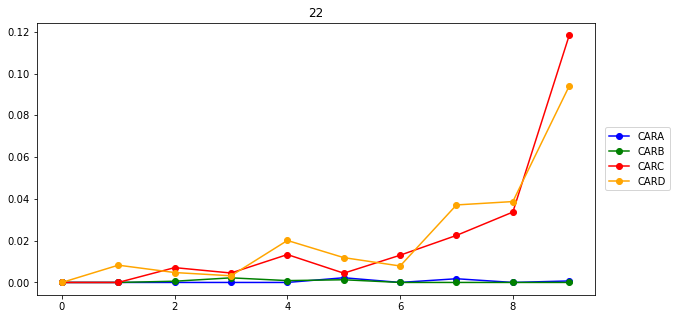

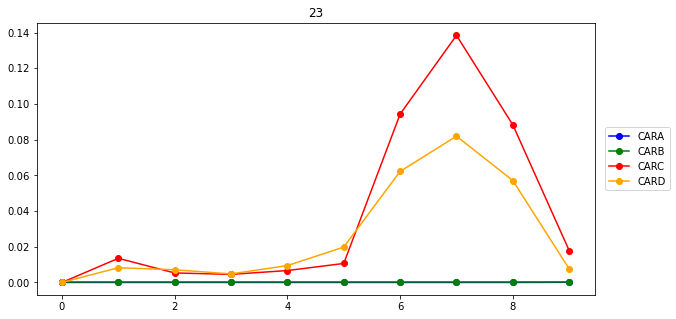

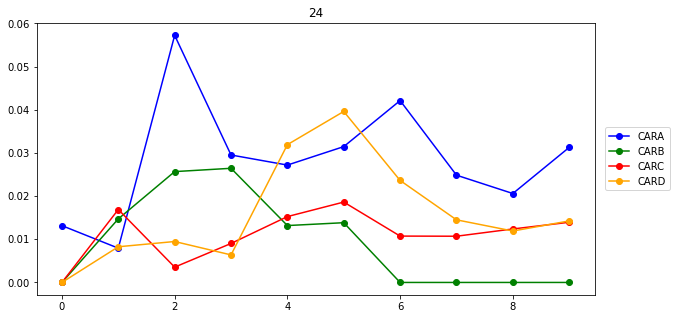

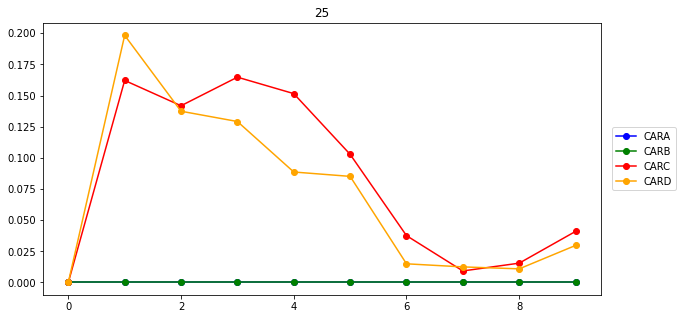

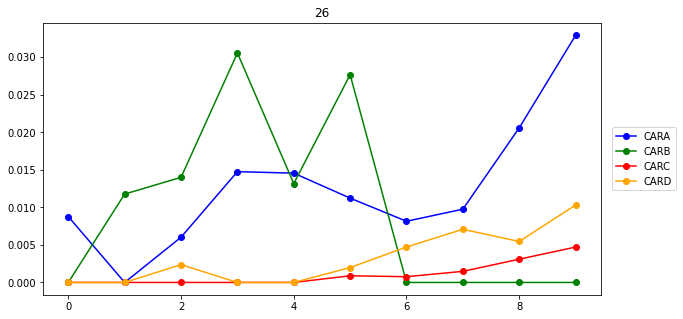

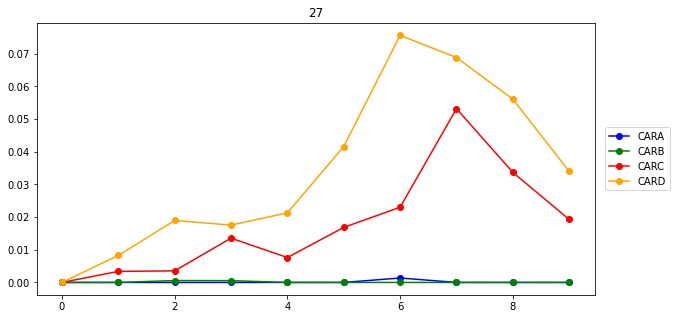

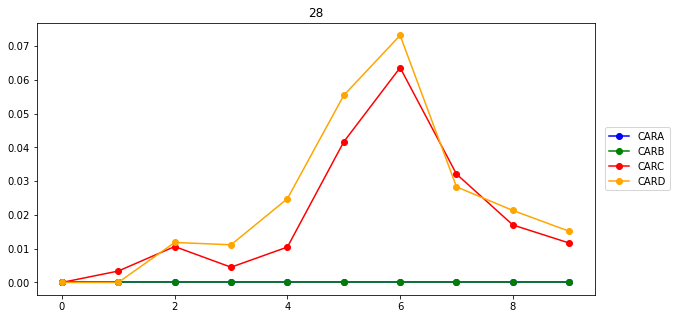

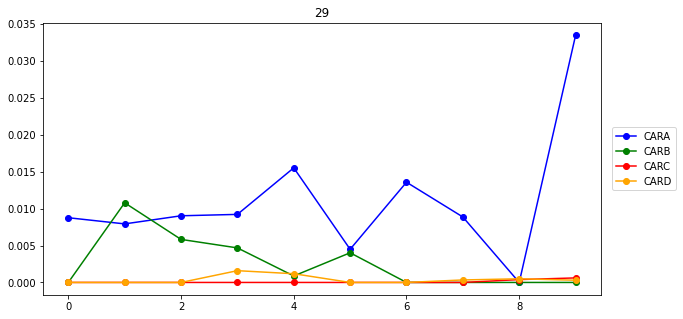

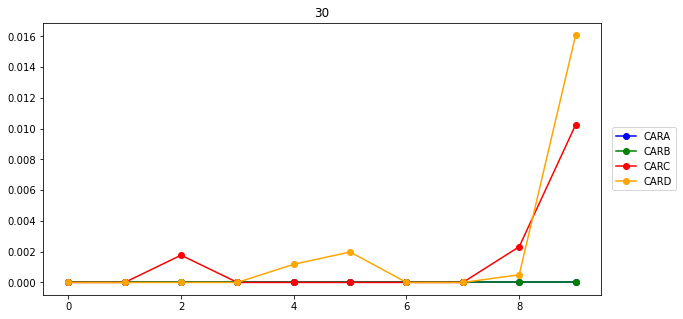

In [173]:
x = np.arange(10)
color_set = random_colors(n_cluster_knn + 1)

for cluster in range(n_cluster_knn + 1):
    plt.figure(figsize = [10,5])
    for i,exp in enumerate(experiments):
        y = list(cluster_dict[cluster][exp].values())
        plt.plot(x,y, label = exp, color = col_arr[i],marker = 'o')
    plt.title(cluster)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', ncol = 1)
    plt.show()




<Figure size 432x288 with 0 Axes>

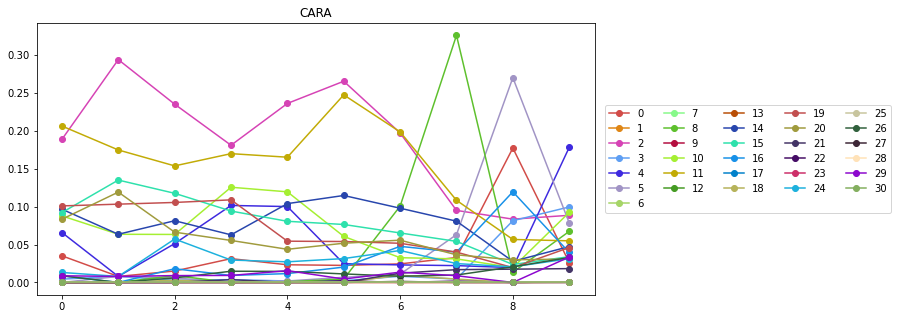

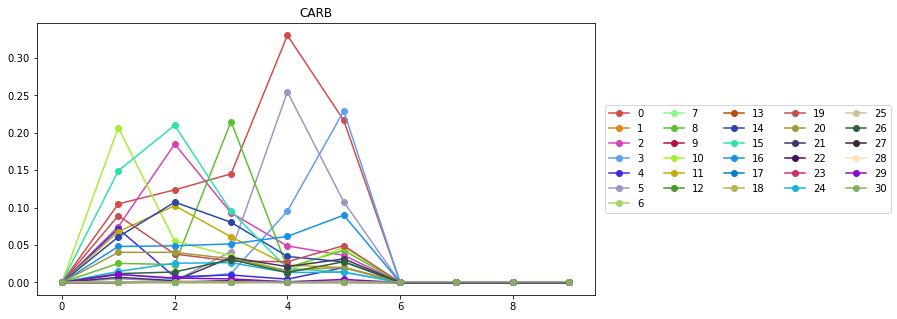

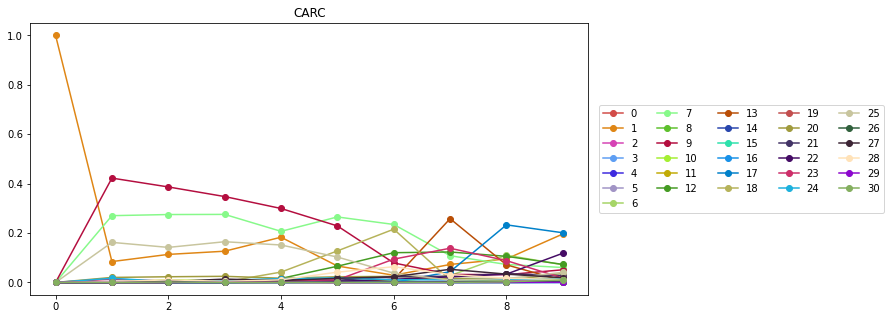

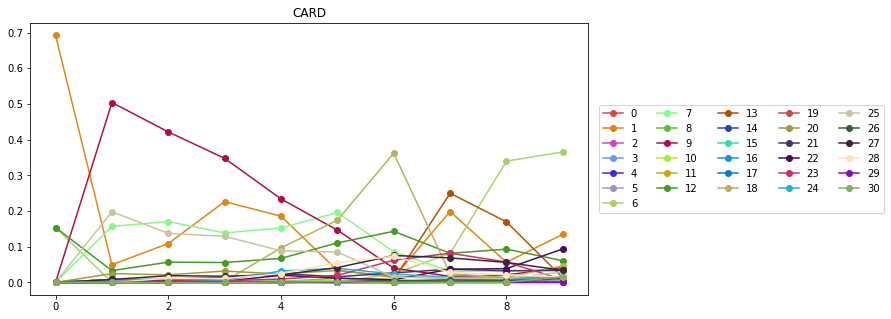

In [169]:
x = np.arange(10)
plt.figure()
color_set = random_colors(n_cluster_knn + 1)

for exp in experiments:
    plt.figure(figsize = [10,5])
    for cluster in range(n_cluster_knn + 1):
        y = list(cluster_dict[cluster][exp].values())
        plt.plot(x,y,color = color_set[cluster], label = cluster, marker = 'o')
    plt.title(exp)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', ncol = 5)
    plt.show()



In [185]:
## SCRUBLET ANALYSIS
doublet_df = pd.read_pickle("./car_t_scrublet_10percentexp.pkl")

In [187]:
umap_['doublet'] = doublet_df

In [189]:
umap_.to_pickle("umap_withcolors_and_doublets.pkl")

In [195]:
arr = []
for cell in umap_.index:
    boolean = umap_.loc[cell,'doublet']
    if boolean: 
        arr.append('red')
    else:
        arr.append('lightgrey')

In [196]:
umap_['c_doublet'] = arr

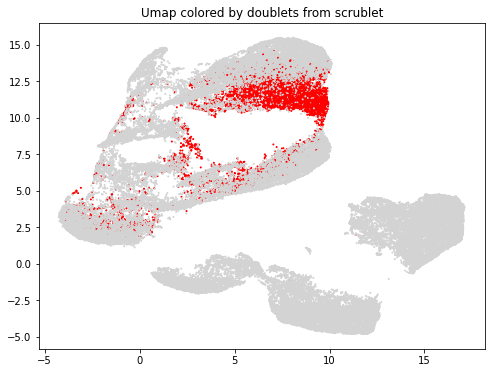

In [197]:
DF = umap_
plt.figure(figsize = [8,6])
plt.scatter(DF['x'],DF['y'], s = 1,cmap = plt.cm.Spectral_r, c = DF['c_doublet'])
plt.title("Umap colored by doublets from scrublet")
plt.show()

percentage of cells in cluster 0  =  9.57
percentage of cells in cluster 1  =  0.0
percentage of cells in cluster 2  =  24.35
percentage of cells in cluster 3  =  11.37
percentage of cells in cluster 4  =  4.39
percentage of cells in cluster 5  =  18.14
percentage of cells in cluster 6  =  0.0
percentage of cells in cluster 7  =  0.0
percentage of cells in cluster 8  =  7.62
percentage of cells in cluster 9  =  0.0
percentage of cells in cluster 10  =  9.45
percentage of cells in cluster 11  =  79.91
percentage of cells in cluster 12  =  0.05
percentage of cells in cluster 13  =  0.0
percentage of cells in cluster 14  =  20.74
percentage of cells in cluster 15  =  6.0
percentage of cells in cluster 16  =  87.22
percentage of cells in cluster 17  =  0.0
percentage of cells in cluster 18  =  0.06
percentage of cells in cluster 19  =  16.48
percentage of cells in cluster 20  =  24.4
percentage of cells in cluster 21  =  3.25
percentage of cells in cluster 22  =  0.37
percentage of cells i

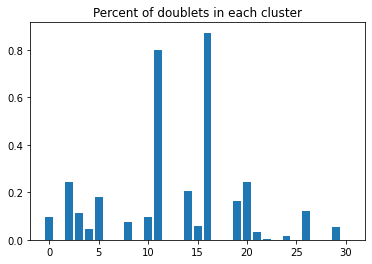

In [205]:
n_cluster_knn = np.amax(umap_["cluster_number"])
percent_array = np.zeros(n_cluster_knn + 1)
i = 0
for cluster in range(n_cluster_knn + 1):
    df = umap_.loc[umap_["cluster_number"] == cluster]
    total_num = len(df)
    doublets = len(df.loc[df["doublet"] == 1])
    percent = doublets/total_num
    percent_array[i] = percent
    i += 1
    print("percentage of cells in cluster", cluster, " = ",np.round(doublets/total_num*100,2))
x = np.arange(n_cluster_knn + 1)
plt.bar(x, percent_array)
plt.title("Percent of doublets in each cluster")
plt.show()

In [200]:
threshold = 0.2
doublet_clusters = []
for i in range(len(percent_array)):
    if percent_array[i] > threshold:
        doublet_clusters.append(i)
doublet_clusters = np.array(doublet_clusters)
print(doublet_clusters)
doublet_clusters = np.array(doublet_clusters)

[ 2 11 14 16 20]


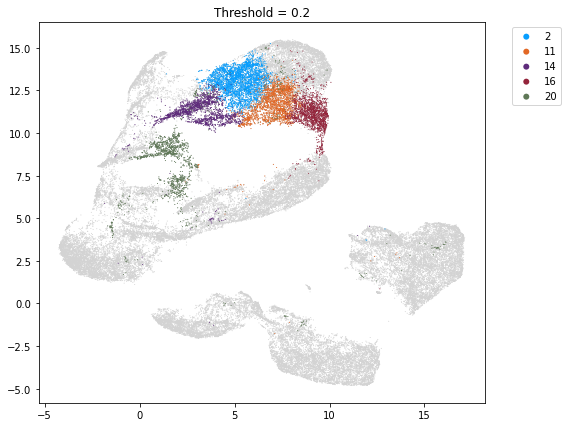

In [203]:
## coloring by cluster ID
communities = umap_['cluster_number']
n_cluster_knn = np.amax(communities)
color_set = random_colors(len(doublet_clusters) + 2)
# color_set = ["red","lime","orange","blue","purple", "pink", "teal"]
plt.figure(figsize = (8,7))
plt.scatter(umap_['x'], umap_['y'],
        s=1, edgecolors='none',color="lightgrey")
i =0
for cluster in range(n_cluster_knn + 1):
    if cluster not in doublet_clusters:
        continue
    cells = umap_.index[communities == cluster]
    i += 1
    plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],
        s=1, edgecolors='none', label = cluster,color=color_set[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=6)
plt.title("Threshold = 0.2")
plt.show()